This notebook implements value iteration on GPU.  We then use this implementation to study the effects of positive and negative rewards in a Markov Decision Process (MDP) to better understand the nature of MDPs.  These observations were what led me to create the FastMDP algorithm described in my Master's Thesis:

https://lib.dr.iastate.edu/etd/17832/

This notebook assumes the reader has some familiarity with Markov Decision Processes and the Value Iteration algorithm.   An overview is provided, but there are many good textbooks and resources that explain MDPs more fully and more clearly.

*Note that to run this notebook on Colab, you will need to change the Runtime to a GPU runtime.  Depending on the amount of RAM used by the run, you may also find you need a Google Colab Pro account and run with the higher RAM option.*

# MDP and Value Iteration Background

A Markov Decision Process is described as the tuple:

$M = (S, A, T, R)$ where:

  * $s \in S$ are the states that represent where the agent can be in the environment
  * $a \in A$ are the actions that can be taken by the agent at some state $s \in S$
  * $T( s, a, s' )$ is the transition function which describes the probability $p( s' | s, a )$ of reaching next state $s' \in S$ after taking action $a \in A$ from state $s \in S$
  * $R$ is known as the reward function and describes how the agent receives reward from the enviornment.  In the most basic form, $R(s)$ is the reward received for reaching state $s$.  More formally, $R( s, a )$  is the immediate reward $r$ received for taking action $a \in A$ from state $s \in S$.  Note that the $R( s )$ formulation is equivalent to $R( s, a )$ when the immediate reward is the same regardless of action, or $\forall s \in S, R(s, a_i) = R(s, a_j), i \neq j$.  


## Deterministic vs Stochastic
Note that an MDP is said to be "deterministic" in cases where an action always results in a known transition with no uncertainty or randomness (that is $\forall s, a:  \exists s' ~ T( s, a, s' ) = 1.0$ and $\sum_{s'} T(s, a, s' ) = 1.0$.)  This means that one transition happens with probabiity 1.0 and all other probabilties are 0.0.

In contrast, an MDP is said to be "stochastic" when taking an action has some element of randomness in which next state $s'$ you will end up in.  In these cases, $\sum_{s'} T(s, a, s') = 1.0$.

## Policy
A "policy" $\pi(s) \in \Pi$ is defined over an MDP and provides a mapping from a state $s \in S$ to a prescribed action $a \in A$ that will be taken from that state.  The policy essentially defines the response of the agent no matter where the agent finds itself in the state space.  

## Value Function
When exeucting the policy $\pi \in \Pi$, the future expected reward at each state $s \in S$ can be computed as an expectation of the immediate reward obtained for taking the action $a = \pi(s)$ iteratively by applying the following recursive relation known as the Bellman update.  This future expected reward is known as the "value" of the state and is denoted $V(s)$.

$V(s) = {\rm I\kern-.3em E}[ R( s, a ) + \gamma \cdot T( s, a, s' ) \cdot V( s' ) ]$,

where ${\rm I\kern-.3em E}$ is an expectation taken over all $s$, $a$, and $s'$, $\gamma \in (0.0, 1.0)$ is known as the "discount factor". 
Gamma serves to balance short term reward versus long term reward.  Small values of $\gamma$ encourage short term rewards and large values of $\gamma$ encourage long term rewards.  (This is known as the "infinite horizon" formulation, but we won't get into that in any more detail here.)

## Value Iteration Overview
The Value Iteration algorithm computes the value function by multiple iterations of applying the Bellman update at each state in the state space. 

$V(s) = r + \gamma \max_{a \in A} \sum_{s' \in S} T( s, a, s' ) \cdot V(s')$

The Bellman update essentially says that the value of the current state is the immediate reward, $r$, plus the future discounted reward of the best possible action that can be taken.  $\gamma$ is responsible for discounting future reward.  We perform a $\max$ over all possible actions.  For each action, we compute an expected value by computing a sum over the possible reachable states $s'$ weighted by the probability of reaching state $s'$ (which may be zero for some combinations of $(s, s')$.)


Each pass through the states in the state space yield a value function that is successively closer to the optimal value function, and the algorithm terminates when the difference between successive updates of the value function falls below some threshold $\epsilon$ known as the Bellman residual.  (We won't get into it here, but the Bellman update process, also known as the Bellman operator $V' = LV$, has been shown to be a contractive mapping and will converge to the true optimal value function $V^* = LV^*$ which is a fixed-point solution.)

This algorithm yields an "exact" result (at least to the $\epsilon$ Bellman residual threshold) and is guaranteed to converge but has two major disadvantages:

1. It may take many, many iterations to converge
2. It requires a table in memory to represent the value function that is the size of the state space $|S|$.

For toy problems, neither of these represent too much of an issue.  However, practical problems typically have state spaces that are very large and the size of the state space tends to grow exponentially.  In practice, very few useful MDPs can fit in memory unless the problem structure allows for a clever representation of the state space.  Other methods have been developed to address many of the shortcomings of Value Iteration, but it is still a very useful algorithm for studying MDPs.

Additionally, a naive implementation of the transition function and reward functions might also choose to represent these as tables in memory.  The transition function is of size $|S| \times |A| \times |S|$ and the reward function is of size $|S| \times |A|$ (assuming R(s,a) formulation).  However, the reward and transition functions often have some pattern or mathematical formula that can represent them and need not always be captured in table form.  (Note that in this notebook, we do use this naive representation of the reward and transition function because it is easier, and because we are working with small MDPs that can fit into memory easily.)






# GPU 

GPUs allow multiple operations to be performed in parallel.  A GPU can be thought of as having thousands of simple CPUs that run very simple programs at the same time.  Usually, each one of these simple programs operates on a small portion of a data set.  For algorithms which perform the same operation over and over on different parts of the data set, GPUs can provide an enormous benefit.

For example, images can be broken down into pixels and each pixel has usually 3 color channels to represent red, green, and blue.  If we think of this as a large array in memory, we might want to write an algorithm that removes all blue from an image.  We could write a program on a CPU that loops over each array element that sets the blue pixel value to 0, where 1 thread iterates over and over on different elements of the array.  

In contrast, on a GPU we might instead launch one thread per pixel where each thread sets the blue pixel value to 0 for only that pixel.  Note that if there are many pixels in the image, this might mean we launch millions of threads.  On a CPU, this might be disastrous as that many threads would have too much overhead to be efficient due to the complexity of the CPU and how it must keep track of threads.  GPUs in contrast are much simpler processors and there is comparatively very little overhead with having enormous numbers of threads.  We describe a problem as "embarrasingly parallel" when each of these threads has very little or no dependency on the operation of other threads.  Because each of our threads is just zeroing out the blue portion of its designated pixel and the thread isn't dependent on the solution provided by any other thread, our example is embarrasingly parallel.

The Value Iteration algorithm is an algorithm that operates iteratively where each iteration gets successively closer and closer to calculating the Optimal Value Function for a Markov Decision Process (MDP).  Within each iteration, a calculation is performed for each state in the state space.  This is very similar to an image with pixels where in this analogy, each state of the state space corresponds to a pixel in an image.  The computation performed on each state in the state space is also very simple and has no dependencies on the results produced by calculations performed on other states, and is therefore also an embarrasingly parallel problem.

This notebook takes advantage of this property of Value Iteration to implement a version of Value Iteration suitable for a GPU.  Note that there are multiple vendors of GPUs and that normally each vendor has their own API for programming the GPU.  The GPUs used on Google Colab are currently (as of the time of this writing) NVIDA GPUs which use an API known as NVIDIA CUDA.  A python library called numba provides some convenient python-based wrappers that use just-in-time compiling to generate GPU code on the fly.  This notebook uses numba's CUDA wrappers to implement the algorithm.  In principle this code could easily be adapted to a native C++ CUDA API without difficulty.  

# Preliminaries

In [1]:


import numpy as np
import operator


import matplotlib.pyplot as plt


import IPython.display as dp
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 

import time

import numba as nb

from timeit import default_timer as timer

# Deterministic MDP with Hard Coded Transition Function

Let's rewrite value iteration as a GPU algorithm.  This is a deterministic transition function.  Actions in this code are hard coded to up, down, left, right.


## Version 1 of code


In [2]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update(xmax, ymax, V_i, V_o, R_gpu, residual_gpu, gamma):
    
    pos = cuda.grid(1)

    #print( pos )
    if pos > xmax * ymax:
      return
  
    x = pos % ymax
    y = pos // ymax

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return

    if y >= ymax:
      return

    # up
    xu = x 
    yu = max( 0, y - 1 )
    vu = V_i[ xu, yu ]

    # left
    xl = max( 0, x - 1 ) 
    yl = y
    vl = V_i[ xl, yl ]

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )
    vd = V_i[ xd, yd ]

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y
    vr = V_i[ xr, yr ]

    # immediate reward
    r = R_gpu[ x, y ]

    # bellman update
    v = r + gamma * max( vu, vl, vd, vr )

    # residual 
    res = abs(v - V_i[ x, y ])

    # update the value 
    V_o[ x, y ] = v

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration(dims, V, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    R_gpu = cuda.to_device(R)

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    count = 0
    while count == 0 or ( residual[0] > epsilon ):   # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      num_threads = dims[0] * dims[1]
      threadsperblock = 256
      blockspergrid = math.ceil(num_threads / threadsperblock)

      ### Perform Bellman upate
      bellman_update[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, R_gpu, residual_gpu, gamma)

      residual = residual_gpu.copy_to_host()
      #print( "count %d: %f" % (count, residual[0]) )

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )
      count += 1 


    return V_o.copy_to_host()



(100, 100) 10000
Solving MDP


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (40) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (40) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


3.474013918079436


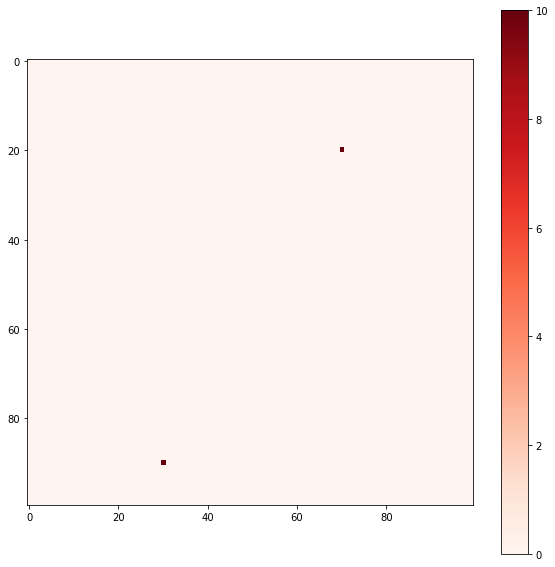

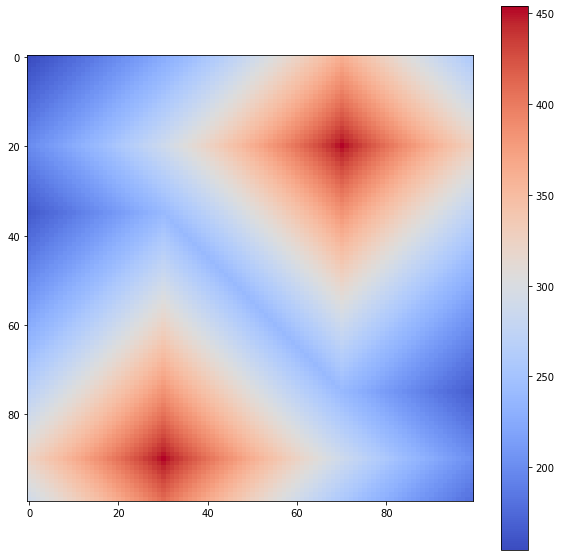

In [3]:

# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4
  

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = 1.0

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

start = timer()    
V_o = numba_value_iteration( dims, V, R, epsilon, gamma )
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

import matplotlib.pyplot as plt
plt.figure( figsize=(10,10))
plt.imshow( R, cmap="Reds" )
plt.colorbar()
#plt.savefig( 'plot1.eps', format='eps', dpi=300)

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure( figsize=(10,10 ))
plt.imshow( V_o, cmap="coolwarm" )
plt.colorbar()
#plt.savefig( 'plot2.eps', format='eps', dpi=300)

plt.savefig( 'metric_space.eps', format='eps', dpi=75)



Now let's build up a 2D grid world environment with a couple of positive rewards and graph the resulting value function.

0.19652194995433092


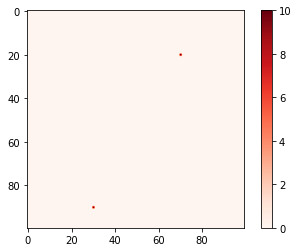

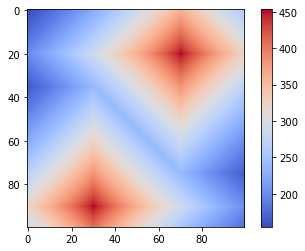

In [4]:

try:
  os.mkdir( 'val_iter' )
except:
  pass
  
dims = (100,100)

V = np.zeros( dims )
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = 1.0

# discount factor
gamma = 0.99

from timeit import default_timer as timer

start = timer()    
V_o = numba_value_iteration( dims, V, R, epsilon, gamma )
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

import matplotlib.pyplot as plt
plt.imshow( R, cmap="Reds" )
plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure()
plt.imshow( V_o, cmap="coolwarm" )
plt.colorbar()


# Deterministic MDP with Arbitrary Transition Function

Here's a reimplemenation of the above that allows an arbitrary transition function to be specified.  Here we build up a transition function that is equivalent to the hard coded one above.

## Version 2 of code

In [5]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, ymax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[2]  # assumes 2-d state space definition

    x, y = cuda.grid( 2 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return

    if y >= ymax:
      return


    # immediate reward
    r = R_gpu[ x, y ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      for xn in range(xmax):
        for yn in range(ymax):

          # probability of transitioning to the next state given
          # the current state and action
          P_n = T_gpu[ x, y, a, xn, yn ]

          # value of next state
          V_n = V_i[ xn, yn ]

          # expected future value of this transition
          V_sum += P_n * ( r + gamma * V_n )
      
      max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x, y ])

    # update the value 
    V_o[ x, y ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st(dims, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[2]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = dims[0] * dims[1]
      threadsperblock = (16, 16)
      blockspergrid_x = math.ceil(dims[0] / threadsperblock[0])
      blockspergrid_y = math.ceil(dims[1] / threadsperblock[1])
      blockspergrid = (blockspergrid_x, blockspergrid_y)      

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 


    return V_o.copy_to_host()



# Stochastic MDP

Here we modify the transition function to be a stochastic transition function where there is some uncertainty in the state that will result from taking any action.  If we take an action from the current state $s$, we assume now that there's a 60% chance we'll make it to this "expected" state that we would have gotten to in the deterministic case above.  However, there is now a 10% chance that we will transtion to a state up, down, left, or right of the "expected" state.  This is a somewhat like a gaussian distribution around that expected state, which I refer to as a "bleed".

(100, 100) 10000
Building transition function
Solving MDP


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


4.599461591802537


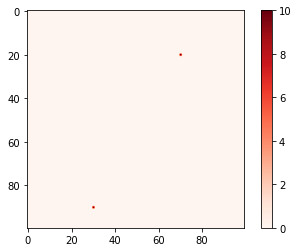

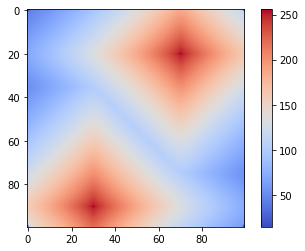

In [6]:

# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

def gen_nbrs(x,y):
    # up
    xu = x 
    yu = max( 0, y - 1 )

    # left
    xl = max( 0, x - 1 ) 
    yl = y

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y

    return [ [xu,yu],
             [xl,yl],
             [xd,yd],
             [xr,yr]
            ]

print( "Building transition function" )
# Create a stochastic transition function for up, down, left, and right
# where there is uncertainty in the resulting state
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    nbr = gen_nbrs( x, y )

    # When we take an action, set a probability of 0.6 that we'll make it 
    # to the desired state
    for a, n in enumerate(nbr):
      xn, yn = n
      T[ x, y, a, xn, yn ] = 0.6

      # And set a probability of 0.1 that we will end up one extra step
      # away from the expected state were this a deterministic MDP.  
      # This is a poor man's gaussian centered around the expected state.
      nbr2 = gen_nbrs( xn, yn )

      for n2 in nbr2:
        xn2, yn2 = n2 
        T[ x, y, a, xn2, yn2 ] = 0.1
    

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = 1.0

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

start = timer()    
V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

import matplotlib.pyplot as plt
plt.imshow( R, cmap="Reds" )
plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure()
plt.imshow( V_o, cmap="coolwarm" )
plt.colorbar()


# More Parallelized Version

Here we're going to try to make the kernel more parallel by altering the inputs.  We're going to have one thread per combination of state, action, and next state.  This will generate a very large number of threads on the GPU, but that's ok.  There is very little overhead on GPUs and having millions of threads can still be efficient.  An on-GPU scheduler is responsible for scheduling the threads on available GPU CUDA cores.  Depending on the particular GPU this may end up being more or less efficient than the previous implementation.

## Version 3 of code

In [7]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st_2_init(xmax, ymax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma, V_sum_gpu ):
  num_actions = T_gpu.shape[2]  # assumes 2-d state space definition

  state, action = cuda.grid( 2 )

  if state >= xmax * ymax:
    return

  x = state % ymax
  y = state // ymax

  if x >= xmax:
    return

  if y >= ymax:
    return

  if action >= num_actions:
    return

  a = action
  index = a + x * num_actions + y * (xmax*num_actions) 
  V_sum_gpu[ index ] = 0

  # Have a single thread zero out the residual for the next
  # iteration
  if state == 0:
    residual_gpu[0] = 0


@cuda.jit
def bellman_update_st_2(xmax, ymax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma, V_sum_gpu ):
  
  num_actions = T_gpu.shape[2]  # assumes 2-d state space definition

  state, action, next_state = cuda.grid( 3 )

  if state >= xmax * ymax:
    return

  x = state % ymax
  y = state // ymax

  if x >= xmax:
    return

  if y >= ymax:
    return

  if action >= num_actions:
    return

  if next_state >= xmax * ymax:
    return

  xn = next_state % ymax
  yn = next_state // ymax

  if xn >= xmax:
    return

  if yn >= ymax:
    return

  # immediate reward
  r = R_gpu[ x, y ]

  # bellman update for stochastic mdp

  # first we have to compute the future expected value of taking
  # an action from this state.  We will keep track of the best
  # value we find in V_sum_gpu
  a = action

  # probability of transitioning to the next state given
  # the current state and action
  P_n = T_gpu[ x, y, a, xn, yn ]

  # value of next state
  V_n = V_i[ xn, yn ]

  # expected future value of this transition
  V_expected = P_n * ( r + gamma * V_n )
  index = a + x * num_actions + y * (xmax*num_actions) 
  cuda.atomic.add( V_sum_gpu, index, V_expected )

    
@cuda.jit
def bellman_update_st_2_reduction(xmax, ymax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma, V_sum_gpu ):
    
    num_actions = T_gpu.shape[2]  # assumes 2-d state space definition

    state = cuda.grid( 1 )

    if state >= xmax * ymax:
      return
  
    x = state % ymax
    y = state // ymax

    if x >= xmax:
      return

    if y >= ymax:
      return

    # reduce over all actions
    max_V = -np.inf
    for a in range(num_actions):
      index = a + x * num_actions + y * (xmax*num_actions)
      max_V = max( max_V, V_sum_gpu[ index ] )
    
    # residual 
    res = abs(max_V - V_i[ x, y ])

    # update the value 
    V_o[ x, y ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 

 

def numba_value_iteration_st_2(dims, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_states = dims[0] * dims[1]
    num_actions = T.shape[2]

    residual = np.array( [ -np.inf ], dtype=V.dtype )
    residual_gpu = cuda.to_device( residual )

    start = timer()

    # We will need to allocate some temporary storage to accumulate
    # values from threads.  This needs to be a 1D array due to cuda.atomic
    # operations requiring 1D array index
    # Note, need to change this to allocate on the device side.
    V_sum_gpu = cuda.to_device( np.zeros( (dims[0] * dims[1] * num_actions) ) ) 


    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      ### Init each cycle
      threadsperblock = (256, 1)
      blockspergrid_x = math.ceil(num_states / threadsperblock[0])
      blockspergrid_y = math.ceil(num_actions/ threadsperblock[1])
      blockspergrid = (blockspergrid_x, blockspergrid_y)      

      bellman_update_st_2_init[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma, V_sum_gpu)
      end1 = timer()


      ### Perform Bellman upate
      threadsperblock = (16, 1, 16)
      blockspergrid_x = math.ceil(num_states / threadsperblock[0])
      blockspergrid_y = math.ceil(num_actions/ threadsperblock[1])
      blockspergrid_z = math.ceil(num_states / threadsperblock[2])
      blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)      

      bellman_update_st_2[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma, V_sum_gpu)
      end2 = timer()

      ### Now perform a reduction over the actions and over the states to determine the residual
      threadsperblock = 256
      blockspergrid_x = math.ceil(num_states / threadsperblock)
      blockspergrid = blockspergrid_x     

      ### Perform Bellman upate
      bellman_update_st_2_reduction[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma, V_sum_gpu)
      end3 = timer()

      residual = residual_gpu.copy_to_host()
      end4 = timer()
      #print( "count %d: %f - %f secs (%f + %f + %f + %f)" % (count, residual[0], end4 - start, end1 - start, end2 - end1, end3 - end2, end4 - end3) )
      start = end4

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )
      count += 1 


    return V_o.copy_to_host()



(100, 100) 10000
Building transition function
Solving MDP
Partially parallelized version: 6.92802813812159 seconds


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (40) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (40) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


More fully parallelized version: 40.666067488025874 seconds


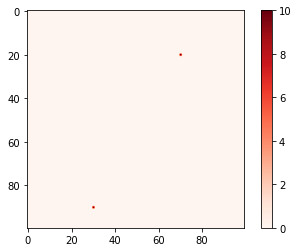

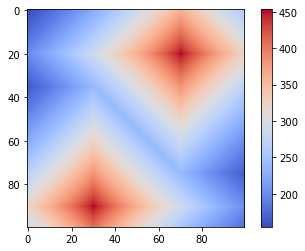

In [8]:

# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

print( "Building transition function" )
# Create a deterministic transition function for up, down, left, and right
# like the one above.
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    # up
    xu = x 
    yu = max( 0, y - 1 )
    T[ x, y, 0, xu, yu ] = 1.0

    # left
    xl = max( 0, x - 1 ) 
    yl = y
    T[ x, y, 1, xl, yl ] = 1.0

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )
    T[ x, y, 2, xd, yd ] = 1.0

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y
    T[ x, y, 3, xr, yr ] = 1.0

    

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = 1.0

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

start = timer()    
V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()
print("Partially parallelized version: %s seconds" % (end - start) ) 

start = timer()    
V_o = numba_value_iteration_st_2( dims, V, T, R, epsilon, gamma )
end = timer()
print("More fully parallelized version: %s seconds" % (end - start) ) 

import matplotlib.pyplot as plt
plt.imshow( R, cmap="Reds" )
plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure()
plt.imshow( V_o, cmap="coolwarm" )
plt.colorbar()


Well, in this environment it looks like the enormous number of threads we generated caused more harm than good.  For the rest of this notebook we will stick to the first version of the algorithm that we wrote.  Note that neither of these algorithms take advantage of most of the optimizations available to the programmer, but they are amazingly faster than a standard CPU based implementation.  (We aren't considering details such as local and shared memory, texture memory, and other trickery normally used to fully optimize an algorithm for a particular GPU architecture.  Often, optimizations made to target one GPU architecture will result in lower performance on another architecture.  Given that in Colab, we should expect that the GPU will change over time, this level of optimization would probably end up being a waste of time.)

# Deterministic MDP with Negative Rewards 


Here we're going to use our fast value iteration algorithm to explore the behavior of positive vs negative rewards in a deterministic MDP.  It will show that negative reward does not propagate outward like a positive reward does.  This is because it is certain that the negative reward can be avoided in this environment.

(100, 100) 10000
Building transition function
Solving MDP


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Partially parallelized version: 6.928272636141628 seconds


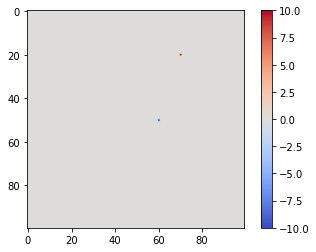

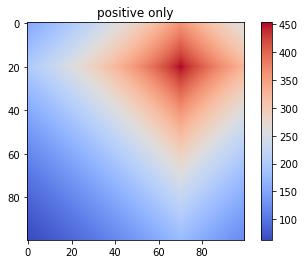

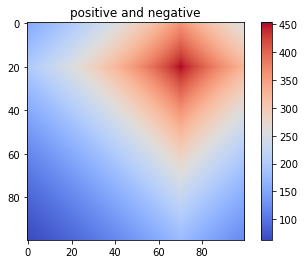

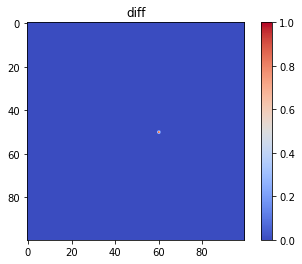

In [9]:

# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

print( "Building transition function" )
# Create a deterministic transition function for up, down, left, and right
# like the one above.
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    # up
    xu = x 
    yu = max( 0, y - 1 )
    T[ x, y, 0, xu, yu ] = 1.0

    # left
    xl = max( 0, x - 1 ) 
    yl = y
    T[ x, y, 1, xl, yl ] = 1.0

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )
    T[ x, y, 2, xd, yd ] = 1.0

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y
    T[ x, y, 3, xr, yr ] = 1.0

    

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
#R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = 1.0

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

start = timer()    
V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()
print("Partially parallelized version: %s seconds" % (end - start) ) 

# now add a negative reward
R[ 50,60 ] = -10
start = timer()    
V_n = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()


import matplotlib.pyplot as plt
plt.imshow( R, cmap="coolwarm" )
plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure()
plt.title( "positive only")
plt.imshow( V_p, cmap="coolwarm" )
plt.colorbar()

plt.figure()
plt.title( "positive and negative")
plt.imshow( V_n, cmap="coolwarm" )
plt.colorbar()

# Now highlight all the states that are different

plt.figure()
plt.title( "diff")
plt.imshow( (V_p - V_n) != 0, cmap="coolwarm" )
plt.colorbar()


# Stochastic MDP with Negative Rewards

Here we will show that there is some difference in the MDP when a stochastic MDP is used.  This is because the stochastic transition function reduces our certainty that the negative reward can be avoided.

(100, 100) 10000
Building transition function
Solving MDP
Partially parallelized version: 16.36101263994351 seconds


/tmp/ipykernel_15384/2863865900.py:128: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(V_p - V_n) , cmap="jet" )


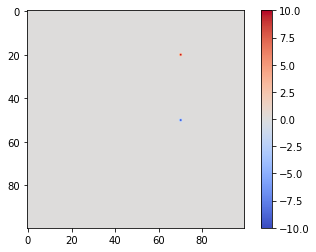

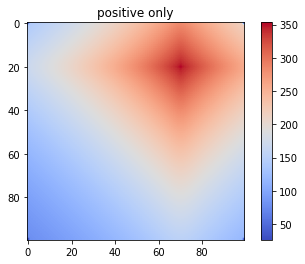

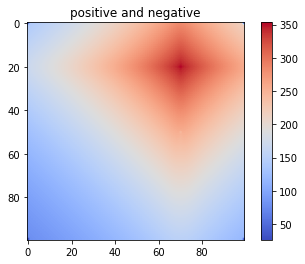

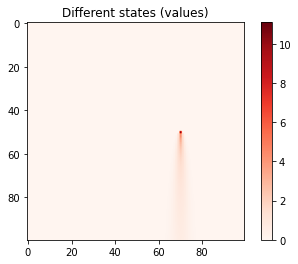

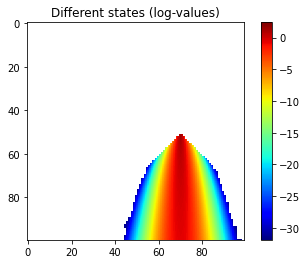

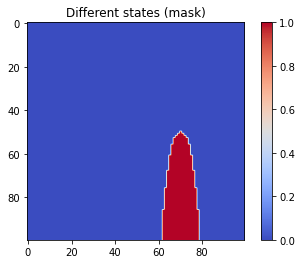

In [10]:

# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

def gen_nbrs(x,y):
    # up
    xu = x 
    yu = max( 0, y - 1 )

    # left
    xl = max( 0, x - 1 ) 
    yl = y

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y

    return [ [xu,yu],
             [xl,yl],
             [xd,yd],
             [xr,yr]
            ]

print( "Building transition function" )
# Create a stochastic transition function for up, down, left, and right
# where there is uncertainty in the resulting state
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    nbr = gen_nbrs( x, y )

    # When we take an action, set a probability of 0.6 that we'll make it 
    # to the desired state
    for a, n in enumerate(nbr):
      xn, yn = n
      T[ x, y, a, xn, yn ] = 0.6

      # And set a probability of 0.1 that we will end up one extra step
      # away from the expected state were this a deterministic MDP.  
      # This is a poor man's gaussian centered around the expected state.
      nbr2 = gen_nbrs( xn, yn )

      for n2 in nbr2:
        xn2, yn2 = n2 
        T[ x, y, a, xn2, yn2 ] = 0.1
    

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
#R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = .01

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

start = timer()    
V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()
print("Partially parallelized version: %s seconds" % (end - start) ) 

# now add a negative reward
R[ 50,70 ] = -10
start = timer()    
V_n = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()


import matplotlib.pyplot as plt
plt.imshow( R, cmap="coolwarm" )
plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure()
plt.title( "positive only")
plt.imshow( V_p, cmap="coolwarm" )
plt.colorbar()

plt.figure()
plt.title( "positive and negative")
plt.imshow( V_n, cmap="coolwarm" )
plt.colorbar()



# Now highlight all the states that are different as a mask
plt.figure()
plt.title( "Different states (values)")
plt.imshow( (V_p - V_n) , cmap="Reds" )
plt.colorbar()

# Now highlight all the states that are different as a mask
plt.figure()
plt.title( "Different states (log-values)")
plt.imshow( np.log(V_p - V_n) , cmap="jet" )
plt.colorbar()

# Now highlight all the states that are different as a mask.
# Note that floating point roundoff / underflow could create
# some false positives.
plt.figure()
plt.title( "Different states (mask)")
threshold = 1.0e-2
mask = np.abs(V_p - V_n) > threshold
plt.imshow( mask, cmap="coolwarm" )
plt.colorbar()


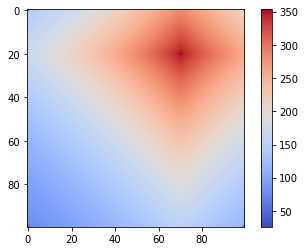

In [11]:
# A quick cell to generate a plot for the dissertation
plt.figure()
plt.imshow( V_p, cmap="coolwarm" )
plt.colorbar()

plt.savefig( 'metric_space_one_reward.eps', format='eps', dpi=75 )


The "differetn states (values)" plot shows that a shadow is cast in the value function by a negative reward in a stochastic MDP.  This "shadow" or "bleed" as I've come to call it is the area where either the reward cannot be avoided, or it's just cheaper to take the penalty than try to go around it. 

The log-values plot shows the differences in greater detail.  Note the colors here correspond to differences in the $10e^{n}$ where n is the color bar value.  So a blue is showing a difference in the value function on the order of $10e^{-50}$.

The mask plot is highlighting any states that are different down to some threshold value ($.01$ in this case).  This would mean that there's a change of greater than 0.01 in the value function as a result of adding this negative reward .


Let's see what happens when we make that negative reward have a really large magnitude compared to the positive rewards.


/tmp/ipykernel_15384/3527200109.py:38: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(V_p - V_n) , cmap="jet" )


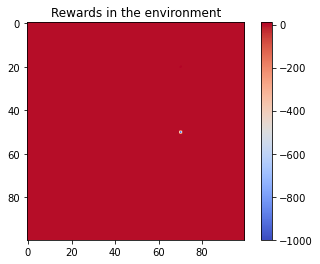

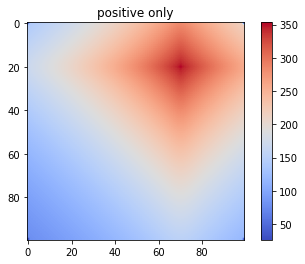

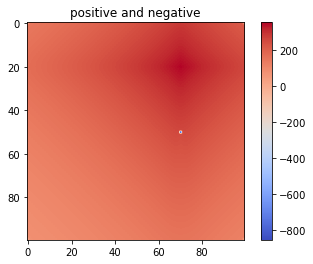

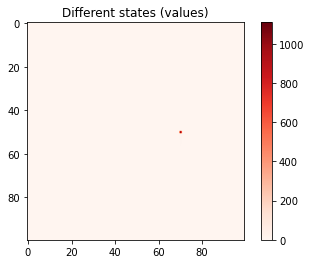

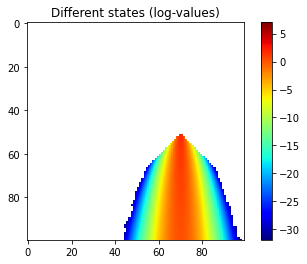

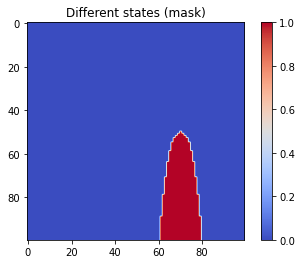

In [12]:
# now add a negative reward
R[ 50,70 ] = -1000
start = timer()    
V_n = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
end = timer()


import matplotlib.pyplot as plt
plt.title( "Rewards in the environment")
plt.imshow( R, cmap="coolwarm" )
plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

plt.figure()
plt.title( "positive only")
plt.imshow( V_p, cmap="coolwarm" )
plt.colorbar()

plt.figure()
plt.title( "positive and negative")
plt.imshow( V_n, cmap="coolwarm" )
plt.colorbar()



# Now highlight all the states that are different as a mask
plt.figure()
plt.title( "Different states (values)")
plt.imshow( (V_p - V_n) , cmap="Reds" )
plt.colorbar()

# Now highlight all the states that are different as a mask
plt.figure()
plt.title( "Different states (log-values)")
plt.imshow( np.log(V_p - V_n) , cmap="jet" )
plt.colorbar()

# Now highlight all the states that are different as a mask.
# Note that floating point roundoff / underflow could create
# some false positives.
plt.figure()
plt.title( "Different states (mask)")
threshold = 1.0e-2
mask = np.abs(V_p - V_n) > threshold
plt.imshow( mask, cmap="coolwarm" )
plt.colorbar()

Comparing the two mask plots and log-value plots, it should be clear that the magnitude of the negative reward has almost no impact on the resulting value function (and therefore the policy).  The negative dip in the value function due to the reward is certainly higher in magnitude (shown by the colorbar scale in the value and log value plots), but the shape of the shadow due to that negative reward (which is what will affect the policy of the agent) hasn't really changed.  This is because the stochasticity of the transition function hasn't changed, so it is no more or less difficult to avoid that reward in the environment than it was before regardless of its magnitude.  This is a really important finding about the nature of negative rewards in MDPs.  Making them of a higher negative magnitude doesn't really alter an agents behavior as much as you would think if the agent has a path around that negative reward.





# Bleed

Let's try to change the amount of stochasticity in the transition function by introducing a concept of a "bleed".  Here "bleed" refers to how we've defined this pseudo-gaussian distribution around the state that an action would take us to normally if our transition function were a deterministic one.  For these purposes, a bleed of 0 corresponds to a deterministic transition function.  Increased bleed means that there is more uncertainty in which state we will end up in.  Let's make a function that allows us to easily set this bleed value so we can examine its effect.

In [13]:

def gen_nbrs(x,y):
    # up
    xu = x 
    yu = max( 0, y - 1 )

    # left
    xl = max( 0, x - 1 ) 
    yl = y

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y

    return [ [xu,yu],
             [xl,yl],
             [xd,yd],
             [xr,yr]
            ]

def gen_transition_function( bleed=0.1 ):

  # The transition function is T( s, a, s' ).
  T = np.zeros( (*dims, num_actions, *dims)  )


  print( "Building transition function" )

  assert bleed >= 0.0 and 4 * bleed < 1.0, "Becasue we have 4 actions, we can't have a bleed whose sum exceeds a probability of 1.0"

  # Here's how certain we are that we will transition to the intended state
  certainty = 1.0 - (4 * bleed)

  # Create a stochastic transition function for up, down, left, and right
  # where there is uncertainty in the resulting state
  xmax = ymax = dim
  for x in range(dim):
    for y in range(dim):

      nbr = gen_nbrs( x, y )

      # When we take an action, set a probability of 0.6 that we'll make it 
      # to the desired state
      for a, n in enumerate(nbr):
        xn, yn = n
        T[ x, y, a, xn, yn ] = certainty

        # And set a probability of 0.1 that we will end up one extra step
        # away from the expected state were this a deterministic MDP.  
        # This is a poor man's gaussian centered around the expected state.
        nbr2 = gen_nbrs( xn, yn )

        for n2 in nbr2:
          xn2, yn2 = n2 
          T[ x, y, a, xn2, yn2 ] = bleed
    
  return T
  

(100, 100) 10000
Solving MDP
Building transition function
Partially parallelized version: 16.223290691850707 seconds


/tmp/ipykernel_15384/2406983882.py:92: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(V_p - V_n) , cmap="jet" )


Building transition function
Partially parallelized version: 16.986625731922686 seconds
Building transition function
Partially parallelized version: 17.190786990104243 seconds


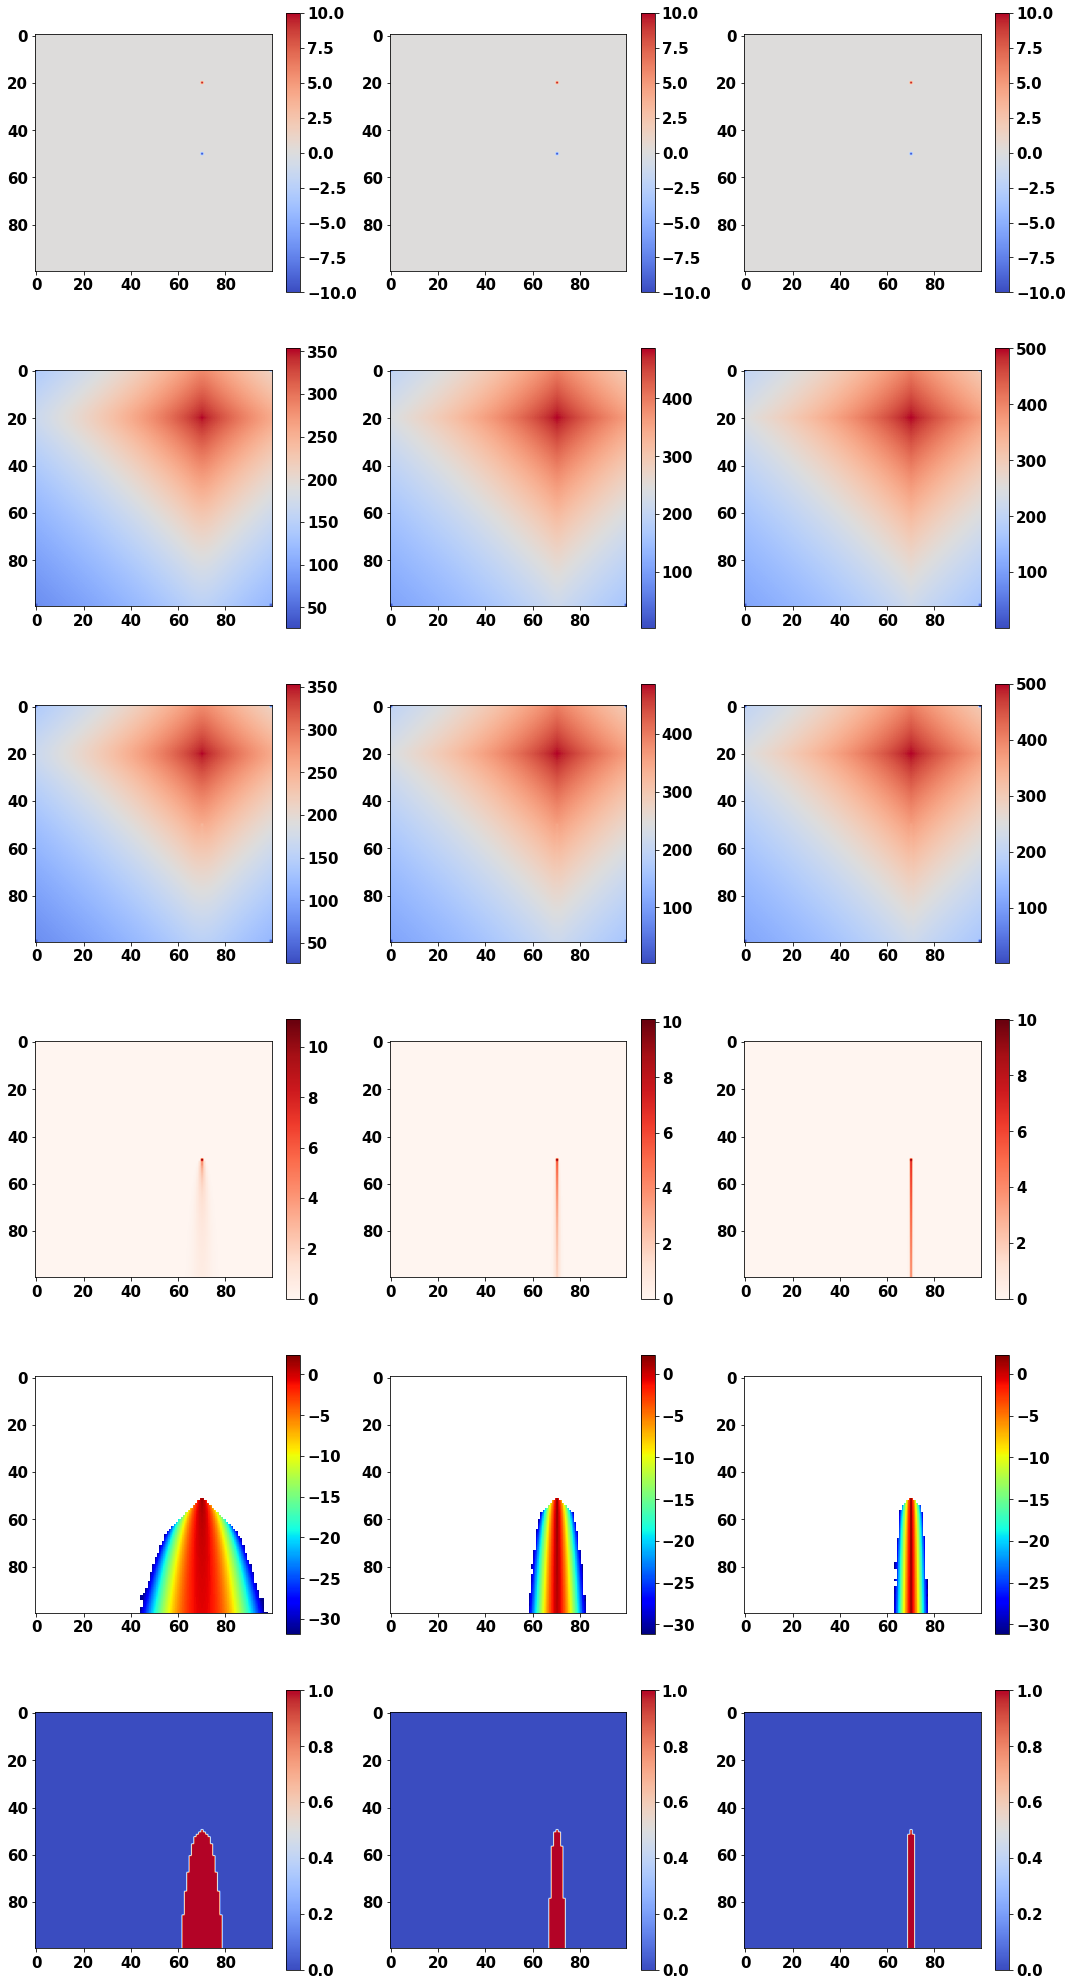

In [64]:


# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
#R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = .01

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

font_size=20
# Increase the font size for EPS plots in the paper
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : font_size}
import matplotlib as mpl
mpl.rc('font', **font)

fig = plt.figure(figsize=(18,36), constrained_layout=False)
gs = fig.add_gridspec(6,3)

for b, bleed in enumerate( [.1, .01, .001] ):
  T = gen_transition_function( bleed )

  # no negative reward
  R[ 50,70 ] = 0
  start = timer()    
  V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  end = timer()
  print("Partially parallelized version: %s seconds" % (end - start) ) 

  # now add a negative reward
  R[ 50,70 ] = -10
  start = timer()    
  V_n = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  end = timer()

  ax = fig.add_subplot(gs[0, b])
  # JRB:  Removing titles from these figures because the font size in the dissertation is too small and
  # isn't passing formatting checks by the graduate college.
  #plt.title( "bleed = %s" % bleed )
  plt.imshow( R, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[1, b])
  #plt.title( "positive only")
  plt.imshow( V_p, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[2, b])
  #plt.title( "positive and negative")
  plt.imshow( V_n, cmap="coolwarm" )
  plt.colorbar()



  # Now highlight all the states that are different as a mask
  ax = fig.add_subplot(gs[3, b])
  #plt.title( "Different states (values)")
  plt.imshow( (V_p - V_n) , cmap="Reds" )
  plt.colorbar()

  # Now highlight all the states that are different as a mask
  ax = fig.add_subplot(gs[4, b])
  #plt.title( "Different states (log-values)")
  plt.imshow( np.log(V_p - V_n) , cmap="jet" )
  plt.colorbar()

  # Now highlight all the states that are different as a mask.
  # Note that floating point roundoff / underflow could create
  # some false positives.
  ax = fig.add_subplot(gs[5, b])
  threshold = 1.0e-2
  #plt.title( "Different states (mask at %f)" % threshold)
  mask = np.abs(V_p - V_n) > threshold
  plt.imshow( mask, cmap="coolwarm" )
  plt.colorbar()

plt.savefig( 'future_stoch_one_peak_bleed.eps', format='eps', dpi=75 )

This shows that as the bleed decreases (as the uncertainty decreases) then the shadow cast by the negative reward becomes more constrained.  This is because with decreased uncertainty in the transition function, we can be more assured that we can successfully avoid the negative reward.

# Bleed with Two Positive Rewards

Let's look at what happens to the shadow when we have two positive rewards.

(100, 100) 10000
Solving MDP
Building transition function
Partially parallelized version: 28.25350596383214 seconds


/tmp/ipykernel_15384/4265736493.py:93: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(V_p - V_n) , cmap="jet" )


Building transition function
Partially parallelized version: 28.9971608761698 seconds
Building transition function
Partially parallelized version: 29.304455660050735 seconds


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


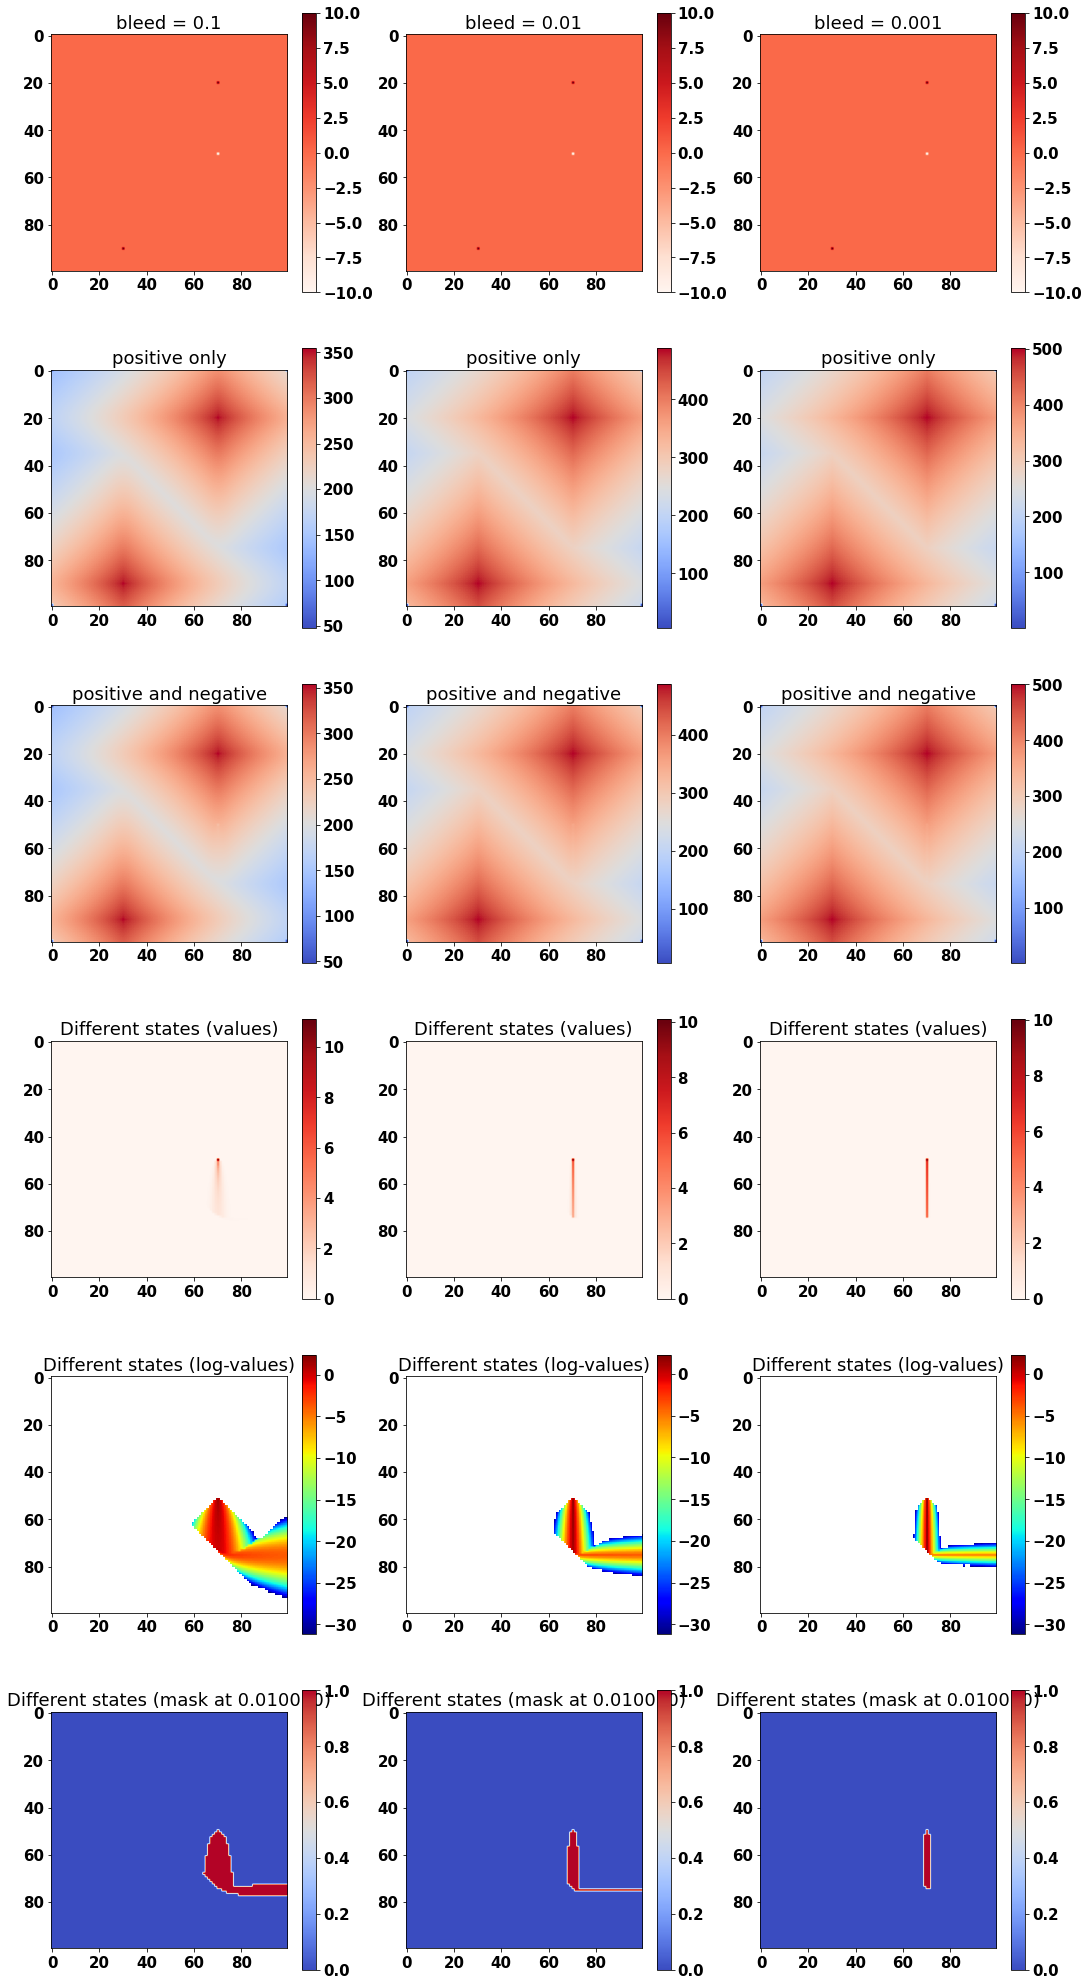

In [18]:

# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,70 ] = 10
R[ 90,30 ] = 10

# define bellman residual threshold
epsilon = .0001

# discount factor
gamma = 0.99

print( "Solving MDP" )

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

font_size=15
# Increase the font size for EPS plots in the paper
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : font_size}
import matplotlib as mpl
mpl.rc('font', **font)


fig = plt.figure(figsize=(18,36), constrained_layout=False)
gs = fig.add_gridspec(6,3)

for b, bleed in enumerate( [.1, .01, .001] ):
  T = gen_transition_function( bleed )

  # no negative reward
  R[ 50,70 ] = 0
  start = timer()    
  V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  end = timer()
  print("Partially parallelized version: %s seconds" % (end - start) ) 

  # now add a negative reward
  R[ 50,70 ] = -10
  start = timer()    
  V_n = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  end = timer()

  ax = fig.add_subplot(gs[0, b])
  plt.title( "bleed = %s" % bleed )
  plt.imshow( R, cmap="Reds" )
  plt.colorbar()

  ax = fig.add_subplot(gs[1, b])
  plt.title( "positive only")
  plt.imshow( V_p, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[2, b])
  plt.title( "positive and negative")
  plt.imshow( V_n, cmap="coolwarm" )
  plt.colorbar()



  # Now highlight all the states that are different as a mask
  ax = fig.add_subplot(gs[3, b])
  plt.title( "Different states (values)")
  plt.imshow( (V_p - V_n) , cmap="Reds" )
  plt.colorbar()

  # Now highlight all the states that are different as a mask
  ax = fig.add_subplot(gs[4, b])
  plt.title( "Different states (log-values)")
  plt.imshow( np.log(V_p - V_n) , cmap="jet" )
  plt.colorbar()

  # Now highlight all the states that are different as a mask.
  # Note that floating point roundoff / underflow could create
  # some false positives.
  ax = fig.add_subplot(gs[5, b])
  threshold = 1.0e-2
  plt.title( "Different states (mask at %f)" % threshold)
  mask = np.abs(V_p - V_n) > threshold
  plt.imshow( mask, cmap="coolwarm" )
  plt.colorbar()


What we see here are the results of two "shadows" being cast in the value function, one due to each positve reward.  Note that the way MDPs work, the agent will always do a hill climb toward the best possible positive reward.  This means that the "shadow" here doesn't quite work the same as the a shadow cast by light sources, but is instead a bit like a gouge made in a hill of sand.  Whereever that gouge lies, everywhere downhill from there will potentially be affected.  Because our grid world only allows the artificial actions of up, down, left, and right, we see the abrupt right angle in this gouge that also makes it look a little pixellated.  Note that as the bleed decreases, the size of the shadow / gouge also decreases because the shadow represents the area where we aren't certain we can avoid the negative reward.   

# Log-Value Function

Here including a little oddity which I'm calling the log-value function.  This is just applying a logarithm to the value function and isn't terribly interesting by itself, but it's interesting to study because it will become important later for a more efficient algorithm.


In [20]:
# Create a really large state space so that exponential decay is more visible
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

def gen_nbrs(x,y):
    # up
    xu = x 
    yu = max( 0, y - 1 )

    # left
    xl = max( 0, x - 1 ) 
    yl = y

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y

    return [ [xu,yu],
             [xl,yl],
             [xd,yd],
             [xr,yr]
            ]

print( "Building transition function" )
# Create a deterministic transition function for up, down, left, and right
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    nbr = gen_nbrs( x, y )

    for a, n in enumerate(nbr):
      xn, yn = n
      T[ x, y, a, xn, yn ] = 1.0


# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 50,50 ] = 10
#R[ 900,300 ] = 10

# define bellman residual threshold
epsilon = .001

# discount factor
gamma = 0.99

#start = timer()    
V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
#end = timer()

(100, 100) 10000
Building transition function


(98, 98) (100, 100)


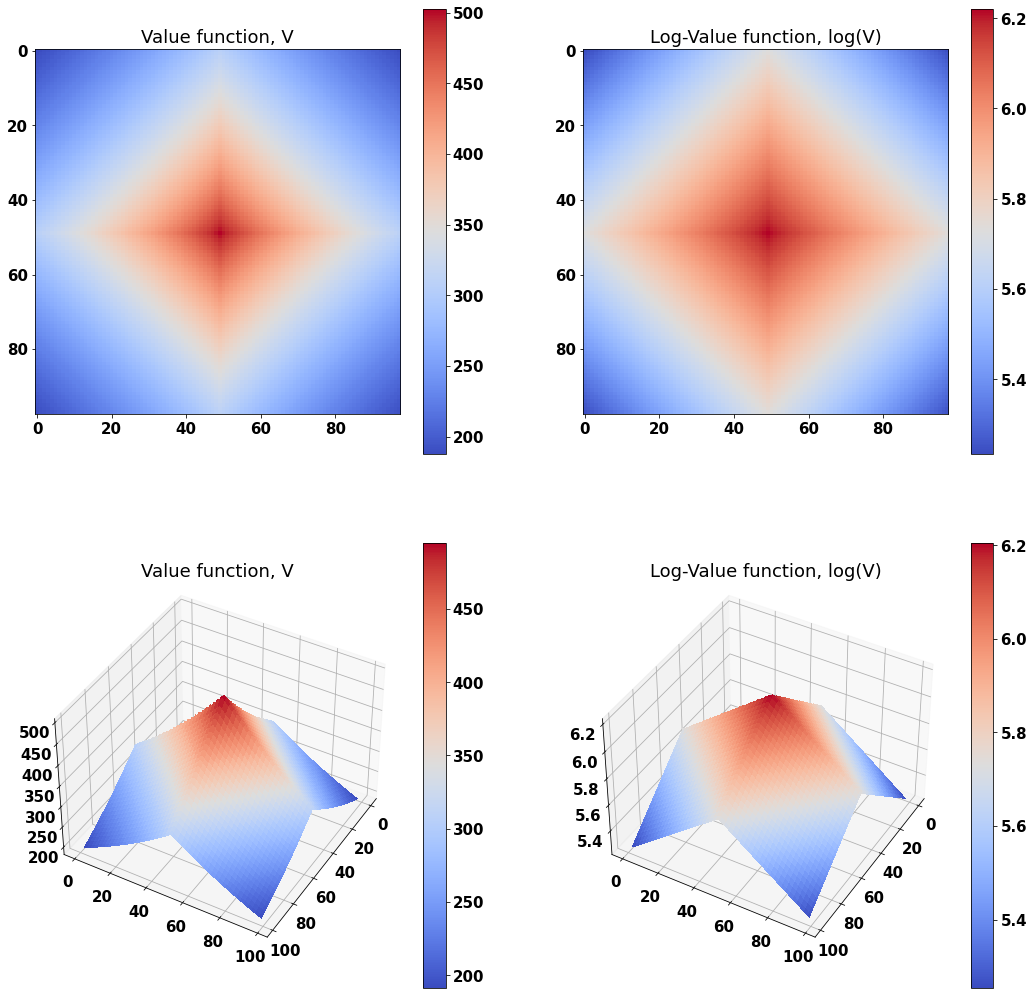

In [21]:


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,18), constrained_layout=False)
gs = fig.add_gridspec(2,2)

#plt.imshow( R, cmap="Reds" )
#plt.colorbar()

#plt.figure()
#plt.imshow( V )
#plt.colorbar()

ax = fig.add_subplot(gs[0, 0])
plt.title( 'Value function, V')
p = plt.imshow( V_o[1:-1,1:-1], cmap="coolwarm" )
plt.colorbar(p)

ax = fig.add_subplot(gs[0, 1])
plt.title( 'Log-Value function, log(V)')
p = plt.imshow( np.log(V_o[1:-1,1:-1]), cmap="coolwarm" )
plt.colorbar(p)

from mpl_toolkits.mplot3d import Axes3D

X = np.arange(1, V_o.shape[0] - 1, 1.0)
Y = np.arange(1, V_o.shape[1] - 1, 1.0)
X, Y = np.meshgrid(X, Y)

Z = V_o[1:-1,1:-1]

print( X.shape, V_o.shape )


ax = fig.add_subplot(gs[1, 0], projection='3d')
plt.title( 'Value function, V')
#plt.imshow( V_o, cmap="jet" )

e=40
a=30

ax.view_init(elev=e, azim=a)
p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)
plt.colorbar(p)

ax = fig.add_subplot(gs[1, 1], projection='3d')
plt.title( 'Log-Value function, log(V)')
ax.view_init(elev=e, azim=a)

#ax.set_zlim( 5, 6 )
p = ax.plot_surface(X, Y, np.log(Z), cmap='coolwarm',
                       linewidth=0, antialiased=False)

plt.colorbar(p)



The left hand plots show the value function in an overhead view and then a 3D view.  The right hand plots show the corresponding log-value plots.  It's a little hard to tell from this small of a state space, but the peaks are decaying exponentially in the value plots on the left.  The log plots however cancel out the exponential decay and show that the corresponding slopes are linear decay rather than exponential decay.  

An important point about this is that at large distances the exponential decay starts to approach zero in the value plots, whereas in the log-value plots the difference between states is still detectable.

When you consider determining the optimal policy from the value function, you typically compare the value at each reachable state.  However, all that is required here is that you compare the relative magnitude of the value function at each reachable state.  The log-value function retains the property that if $V(s_1) \leq V(s_2)$, then $\log V(s_1) \leq \log V(s_2)$.  The log-value function when represented with floating point numbers (32-bit or 64-bit) has a certain smallest representable number and below this limit numbers can no longer be distinguished.  While this is less of an issue for 64-bit floating point, it is noticable for 32-bit floating point when the size of the state space is large.  The log-value representation of the value function therefore makes it easier at long distances to compare the relative value of two states which are very close to zero.

# Negative Reward Propagation Revisited

Let's take a look at MDPs with only negative rewards (no positive rewards).  I've heard from people that they've observed that negative rewards do propagate outward in some MDPs they've studied.  One observation was that the MDP has only negative rewards and no positive rewards.


In [22]:
# Create a really large state space so that exponential decay is more visible
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is up, left, down, right.  If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 4

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

def gen_nbrs(x,y):
    # up
    xu = x 
    yu = max( 0, y - 1 )

    # left
    xl = max( 0, x - 1 ) 
    yl = y

    # down
    xd = x 
    yd = min( ymax-1, y + 1 )

    # right
    xr = min( xmax-1, x + 1 ) 
    yr = y

    return [ [xu,yu],
             [xl,yl],
             [xd,yd],
             [xr,yr]
            ]

print( "Building transition function" )
# Create a deterministic transition function for up, down, left, and right
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    nbr = gen_nbrs( x, y )

    for a, n in enumerate(nbr):
      xn, yn = n
      T[ x, y, a, xn, yn ] = 1.0


# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 50,50 ] = -10
#R[ 900,300 ] = 10

# define bellman residual threshold
epsilon = .001

# discount factor
gamma = 0.99

#start = timer()    
V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
#end = timer()

(100, 100) 10000
Building transition function


(98, 98) (100, 100)


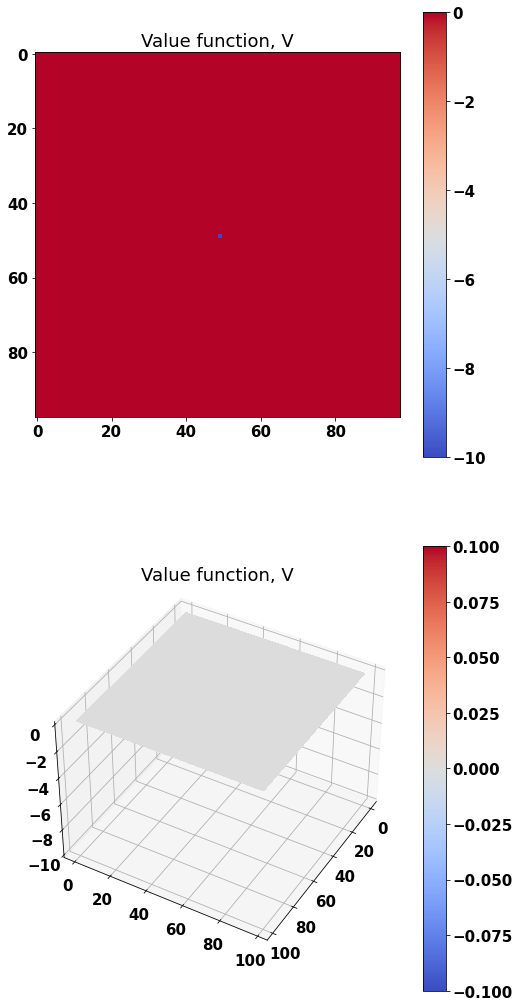

In [23]:


import matplotlib.pyplot as plt

def plot_it( V_o ):

  fig = plt.figure(figsize=(18,18), constrained_layout=False)
  gs = fig.add_gridspec(2,2)

  #plt.imshow( R, cmap="Reds" )
  #plt.colorbar()

  #plt.figure()
  #plt.imshow( V )
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 0])
  plt.title( 'Value function, V')
  p = plt.imshow( V_o[1:-1,1:-1], cmap="coolwarm" )
  plt.colorbar(p)


  from mpl_toolkits.mplot3d import Axes3D

  X = np.arange(1, V_o.shape[0] - 1, 1.0)
  Y = np.arange(1, V_o.shape[1] - 1, 1.0)
  X, Y = np.meshgrid(X, Y)

  Z = V_o[1:-1,1:-1]

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[1, 0], projection='3d')
  plt.title( 'Value function, V')
  #plt.imshow( V_o, cmap="jet" )

  e=40
  a=30

  ax.view_init(elev=e, azim=a)
  p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)



plot_it( V_o )

So no propagation of a single point reward.  Let's try a line.

(98, 98) (100, 100)


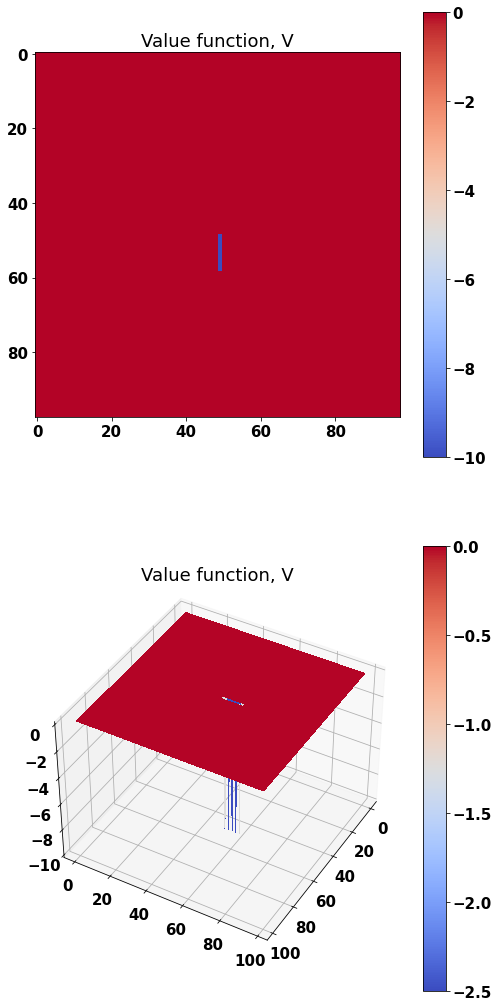

In [24]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 50:60,50 ] = -10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plot_it( V_o )

No propagation evident here either.  Note here that the magnitude of negative rewards is around -10 which matches the magnitude of negative reward that we've defined.

Let's try a square with sides of length 10.


(98, 98) (100, 100)


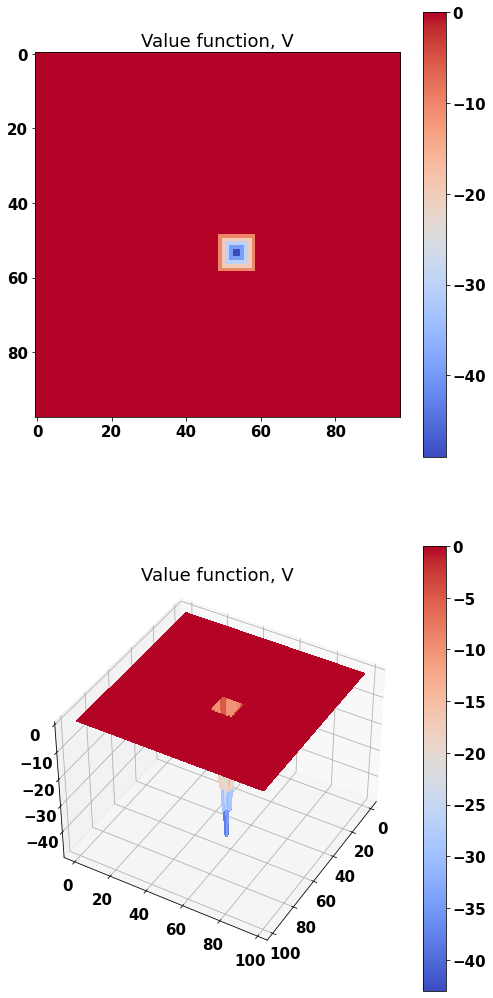

In [25]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 50:60,50:60 ] = -10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plot_it( V_o )

Now we're seeing some propagation, but only to the border where the negative reward is defined.  It's not propagating outward into the region where no negative reward is defined, however.  Note the magnitude of the value is around -40 or -50.


In [26]:
V_o.min()

-49.00995009999999

The magnitude of this value is more extreme than the value of the negative rewards we have defined.  It is almost 5 times the magnitude and is consistent with the idea that to get from the center of the negative reward (the state at $(55,55)$ to the edge of the negative rewards) it takes about 5 steps to reach the boundary.  If we compute the value manually we get:
 


In [27]:
r1 = r2 = r3 = r4 = r5 = -10
g = gamma

# Compute the discounted future reward of taking a penalty of -10 at each step.
r1 + g * ( r2 + g * ( r3 + g * ( r4 + g * (r5) )))

-49.00995009999999

So if that's the pattern, then if we make the reward 20 on each side, we should get a minimum value in the value function of taking 10 negative rewards, or:

In [28]:
r1 = r2 = r3 = r4 = r5 = r6 = r7 = r8 = r9 = r10 = -10

# Compute the discounted future reward of taking a penalty of -10 at each step.
r1 + g * ( r2 + g * ( r3 + g * ( r4 + g * (r5 + g * ( r6 + g * (r7 + g * ( r8 + g * (r9 + g* (r10 )))))) )))

-95.6179249911955

In [29]:
# As a recursive function:

def expected_future_reward( gamma, rs ):
  v = 0

  r = rs[0]

  v += r

  if len(rs) > 1:
    v += gamma * expected_future_reward( gamma, rs[1:] )
  
  return v

rs = [ -10 ] * 10  # list of the 10 negative rewards

expected_future_reward( g, rs )


-95.6179249911955

Let's test that hypothesis:

In [30]:
R = np.zeros( dims )

# define some rewards in the reward function, a square with sides of length 20
R[ 40:60,40:60 ] = -10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

V_o.min()

-95.6179249911955

(98, 98) (100, 100)


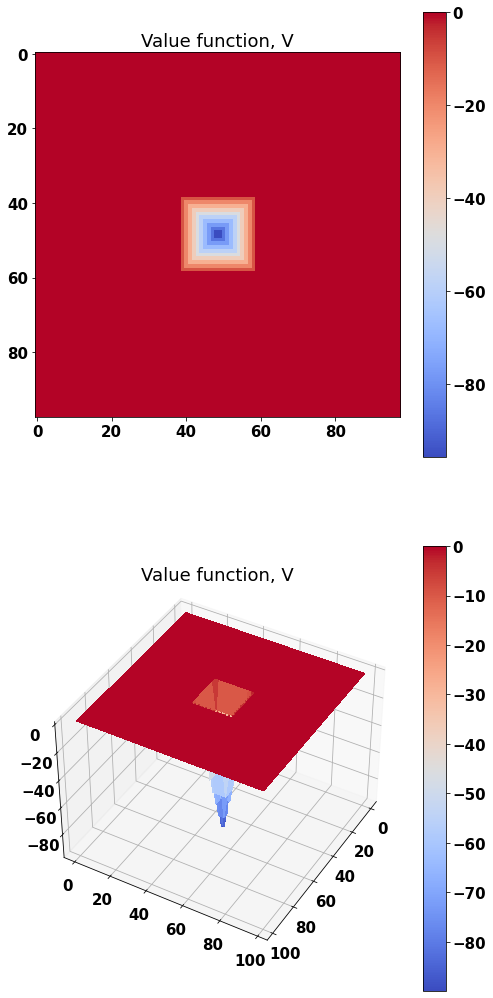

In [31]:
plot_it( V_o )

Let's further test it by extending the square into a rectangle where the best action that can be taken is still a 10 step path to escape the negative rewards.  Our minimum in the value funciton should stay the same.

In [32]:
R = np.zeros( dims )

# define some rewards in the reward function, a rectangle with sides of length 20
R[ 40:60,30:70 ] = -10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

V_o.min()

-95.6179249911955

(98, 98) (100, 100)


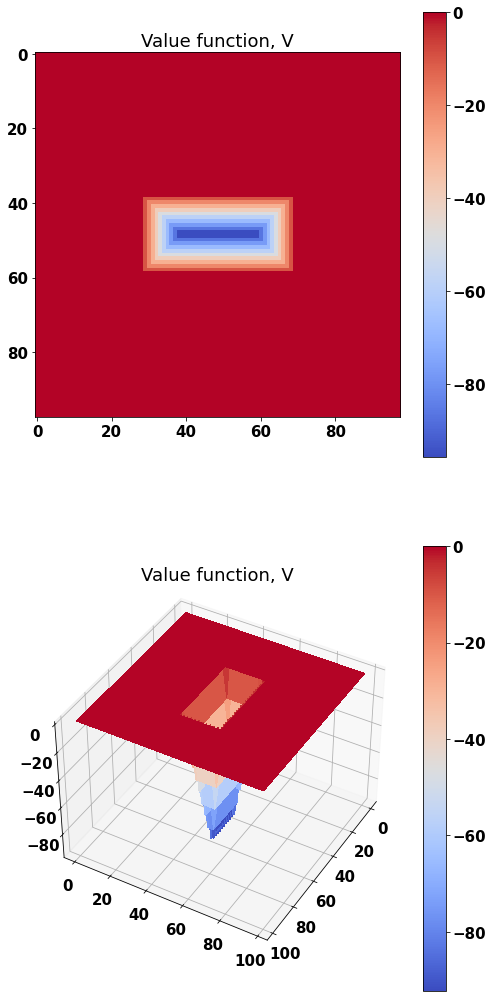

In [33]:
plot_it( V_o )

Let's fill the bottom right corner with negative rewards and see what happens

(98, 98) (100, 100)


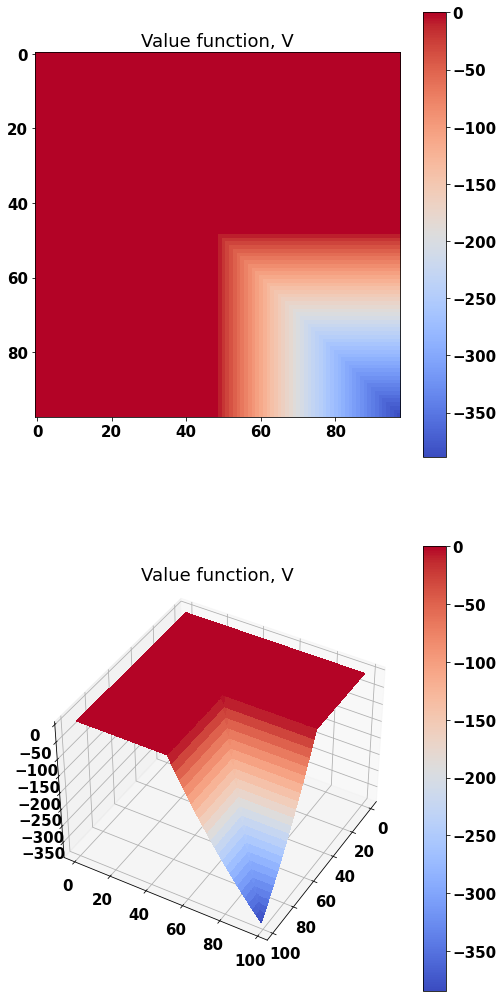

In [34]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 50:100,50:100 ] = -10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plot_it( V_o )

In [35]:
V_o.min()

-394.9939328624632

It should require 50 steps from the bottom right corner to escape the negative rewards.

In [36]:

rs = [ -10 ] * 50  # list of the negative rewards along the path of escape

expected_future_reward( g, rs )

-394.9939328624632

Now lets fill the whole space so that there's no "escape" from the reward.

(98, 98) (100, 100)


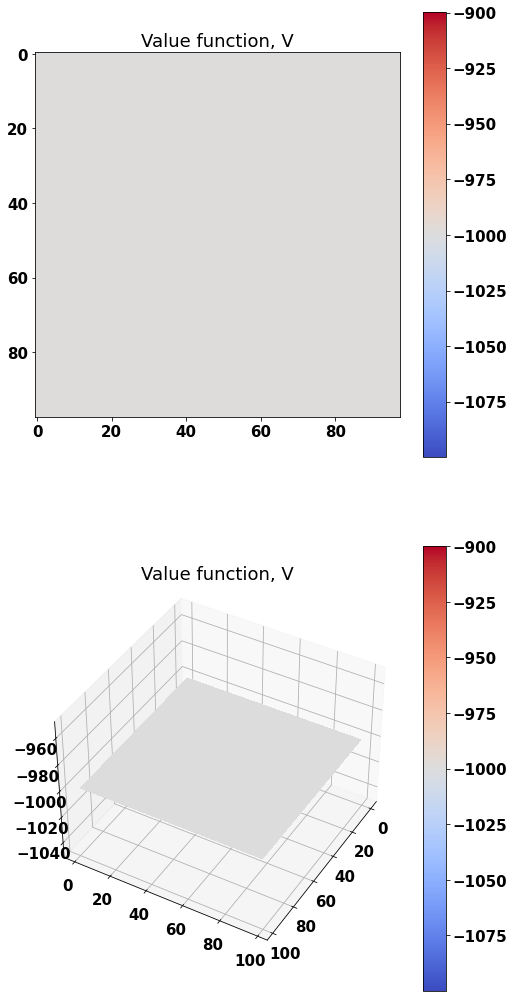

In [37]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 0:100,0:100 ] = -10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plot_it( V_o )

In [38]:
V_o.min(), V_o.max()

(-999.9015742709016, -999.9015742709016)

In [39]:
rs = [ -10 ] * 100  # list of the negative rewards along the path of escape

expected_future_reward( g, rs )

-633.9676587267704

What happened here?  The world is only 100 x 100, so how is our value greater than the length of the world?  It's because this problem is formulated as a non-terminating MDP where there are no absorbing states.  We've also defined our discount factor $\gamma$ and are using what is known as the "infinite horizon" MDP formulation.  This means that mathematically the problem is sovled as if the agent were to take an infinite number of steps in the world.  Because future steps are (recursively) discounted by gamma, this results in a geometric series and the series has a limit.  We can see this by calling our recursive function with larger sequences:

In [40]:

for n in [ 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950 ]:  # beyond 950 we reach maximum recursion level
  v = expected_future_reward( g, [-10] * n )
  print( "n %d: v %f" %( n, v ) )

n 10: v -95.617925
n 100: v -633.967659
n 200: v -866.020325
n 300: v -950.959106
n 400: v -982.049447
n 500: v -993.429517
n 600: v -997.594991
n 700: v -999.119689
n 800: v -999.677778
n 900: v -999.882056
n 950: v -999.928643


It should be clear that the value is approaching the value that we see from value iteration.  The geometric mean converges to:

$$
\begin{align}
V &= r + \gamma( r + \gamma( r + \gamma(r ...) ) ) \\
  &= r + \gamma r + \gamma^2( r + \gamma(r ...) ) \\
  &= r + \gamma r + \gamma^2 r + \gamma^3( r ... ) ) \\
  &= r + \gamma r + \gamma^2 r + \gamma^3 r + \gamma^4 r ... \\
  &= r ( \gamma + \gamma^2 + \gamma^3 + \gamma^4 + ... ) \\
  &= r \sum_{i=1}^{\infty} \gamma^i 
\end{align}
$$

As $\gamma$ is constrainted to the range $(0, 1)$, this series converges to $\frac{1}{1 - \gamma}$, leading to a total value of:

$$ 
V = \frac{r}{1 - \gamma}
$$


In [41]:
-10 / (1 - gamma)

-999.9999999999991

In [42]:
gamma

0.99

Finally, let's put negative reward everywhere except for the center of the state space.  We now know that this should cause all states to try to "escape" the negative reward towards this center state $Z$ where there is no penalty for being there.

(98, 98) (100, 100)


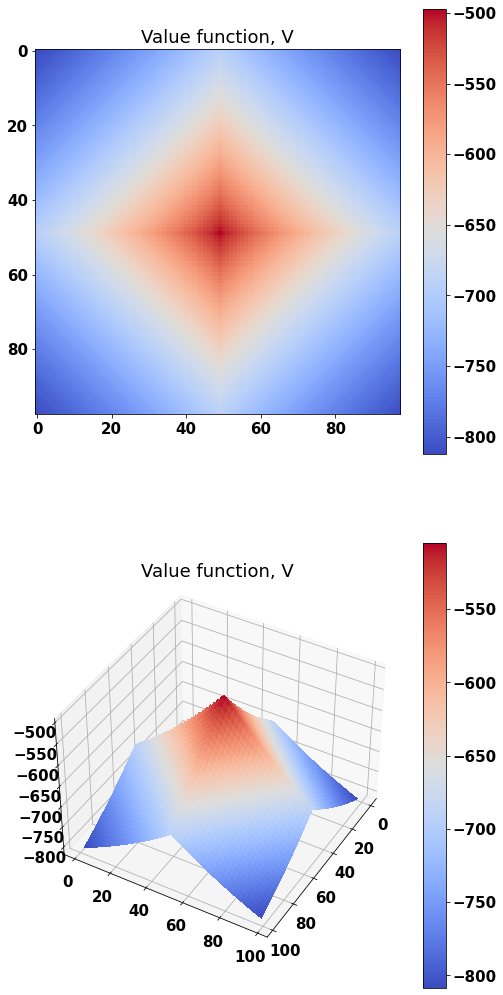

In [43]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 0:100,0:100 ] = -10
R[ 50, 50 ] = 0

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plot_it( V_o )

Note that this looks very similar to an MDP with a single positive reward and explains how you can still obtain a region of "attraction" in the state space using only negative rewards.

(98, 98) (100, 100)


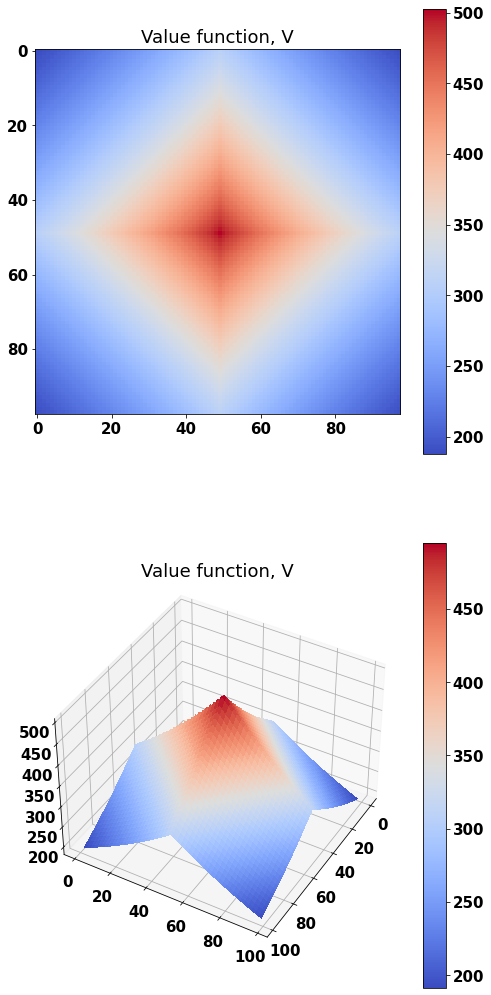

In [44]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 0:100,0:100 ] = 0
R[ 50, 50 ] = 10

V_o = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plot_it( V_o )

## Conclusions

So what conclusions can we draw here about negative reward propagation?

If we can informally describe the region with negative rewards ($N = \{ s \in S | R(s) < 0 \}$ as the "negative zone" and the region with no rewards ($Z = \{ s \in S | R(s) = 0 \}$) as the "free zone", then we can say that when only negative rewards are present in an MDP, negative reward propagates from the "center" of $Z$ outward to $N$ if possible.

We saw earlier that when negative and postive rewards are present in the environment, the effect of the negative reward is to create a "deep spike" in the reward function where the negative rewards are present along with a very shallow "shadow" in the reward function that "flows downhill" in the value function away from the dominant positive reward.  While I don't yet have a closed-form way to describe that shadow's magnitude (which is nearly inconsequential), I believe that shadow represents the region in which we can't guarantee that a negative reward can be avoided.  Anectdotally, this corresponds to the tradeoff of going as close as possible to the edge of a hole without getting so close as you will fall in while continuing toward the positive rewards.  And due to relatively inconsequential magnitdue of the shadow, while it is an approximation until a closed form solution is found, it is still a useful approximation to say that point-source negative rewards (negative rewards that take up one state) do not propagate in this environment.




# Positive Reward with a Fuel Cost

One trick that is often employed to force an agent to take the shortest path through an MDP is to define a "fuel cost" for every action.  When considering two paths $p_1, p_2$ between two states $s_1, s_2$, if the path length $|p_1| > |p_2|$, then path $p_1$ will incur more penalty.  This tends to drive the agent to choose the shortest path.

Normally fuel penalties are chosen to be very small compared to the magnitudes of other rewards in the MDP.  Let's try that concept here and see what happens:





In [45]:
R = np.zeros( dims )

epsilon = .0001  # lets make it really small

# define some rewards in the reward function
R[ 50, 50 ] += 10        # add in a positive reward

V_1 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

R = np.zeros( dims )
R[ 0:100,0:100 ] += -.1  # fuel cost
V_2 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

R = np.zeros( dims )
R[ 50, 50 ] += 10        # add in a positive reward
R[ 0:100,0:100 ] += -.1  # fuel cost
V_3 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )



(98, 98) (100, 100)
(98, 98) (100, 100)
(98, 98) (100, 100)


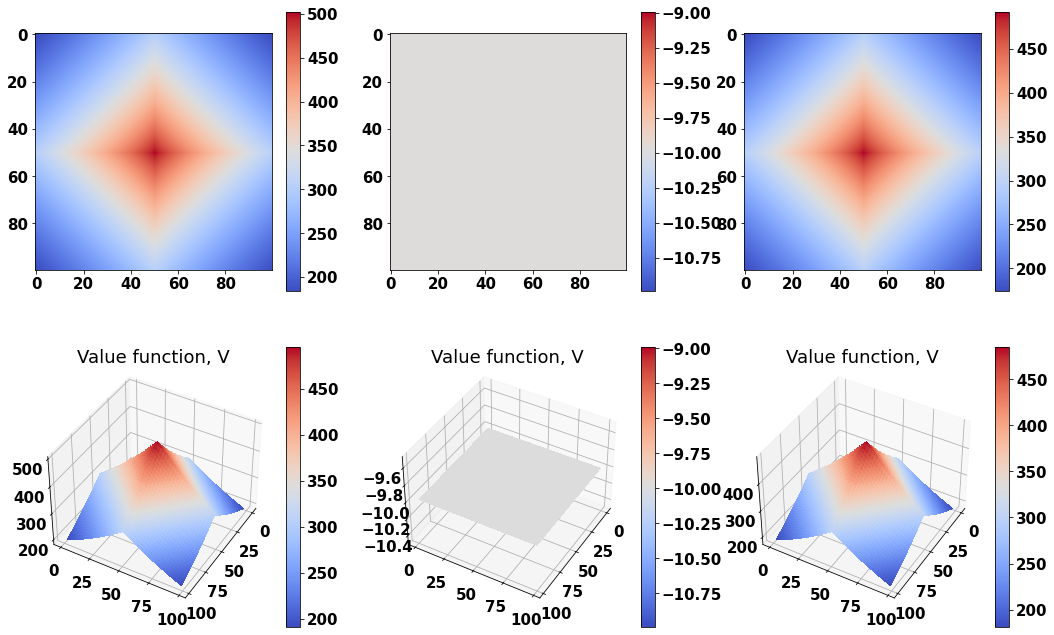

In [46]:


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18,36), constrained_layout=False)
gs = fig.add_gridspec(6,3)

for b, V_o in enumerate( [V_1, V_2, V_3] ):

  ax = fig.add_subplot(gs[0, b])
  plt.imshow( V_o, cmap="coolwarm" )
  plt.colorbar()


  from mpl_toolkits.mplot3d import Axes3D

  X = np.arange(1, V_o.shape[0] - 1, 1.0)
  Y = np.arange(1, V_o.shape[1] - 1, 1.0)
  X, Y = np.meshgrid(X, Y)

  Z = V_o[1:-1,1:-1]

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[1, b], projection='3d')
  plt.title( 'Value function, V')
  #plt.imshow( V_o, cmap="jet" )

  e=40
  a=30

  ax.view_init(elev=e, azim=a)
  p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)


In [47]:
V_1.min(), V_1.max()

(183.93094814547956, 502.5076610735047)

In [48]:
V_2.min(), V_2.max()

(-9.990167836820367, -9.990167836820367)

In [49]:
V_3.min(), V_3.max()

(173.93094814547962, 492.5076610735048)

In [50]:
(V_1+V_2).min(), (V_1+V_2).max()

(173.94078030865919, 492.51749323668434)

This shows that a fuel cost applied uniformly across the space is simply a sum of the two value functions.

# Shadows from Blocks of Negative Reward

Here I want to explore what happens when there are positive rewards in the space along with blocks of negative rewards.

*Note this section is a work in progress*

In [51]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,50 ] = 1

V_base = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )


In [52]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,50 ] = 1
R[ 70,50 ] = -10

V_1 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )



In [53]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,50 ] = 1
R[ 70,45:55 ] = -10

V_2 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

In [54]:
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,50 ] = 1
R[ 70,40:60 ] = -10

V_3 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )



In [65]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D



def plot_them( V_base, plots ):

  fig = plt.figure(figsize=(18,36), constrained_layout=False)
  gs = fig.add_gridspec(6,len(plots) )

  X = np.arange(1, plots[0].shape[0] - 1, 1.0)
  Y = np.arange(1, plots[0].shape[1] - 1, 1.0)
  X, Y = np.meshgrid(X, Y)

  for b, V_o in enumerate( plots ):

    row = 0

    ax = fig.add_subplot(gs[row, b]); row += 1
    # JRB: Removing titles because the font size is too small in the dissertation and is failing 
    # formatting checks by the graduate college.
    #plt.title( 'Value function, V')
    p = plt.imshow( V_o, cmap="coolwarm" )
    plt.colorbar( p )

    ax = fig.add_subplot(gs[row, b]); row += 1
    #plt.title( 'Diff from baseline')
    p = plt.imshow( V_o - V_base, cmap="coolwarm" )
    plt.colorbar( p )




    Z = V_o[1:-1,1:-1]

    print( X.shape, V_o.shape )


    ax = fig.add_subplot(gs[row, b], projection='3d'); row += 1
    #plt.title( 'Value function, V')
    #plt.imshow( V_o, cmap="jet" )

    e=30
    a=30

    ax.view_init(elev=e, azim=a)
    p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                          linewidth=0, antialiased=False)
    plt.colorbar(p)

    if False:
        # Plot the log value functions if desired.  I disabled these because they didn't really add anything and made the plot harder to see in the dissertation
        if V_o.min() >= 0:
          logZ = np.log(Z)
          logV = np.log(V_o)
          title = 'Log Value function, log(V)'
        else: 
          logZ = np.log(Z   + abs(V_o.min()) )
          logV = np.log(V_o + abs(V_o.min()) )
          title = 'Augmented Log Value function, log(V)'

        ax = fig.add_subplot(gs[row, b]); row += 1
        #plt.title( title )  
        p = plt.imshow( np.log(V_o + np.abs(V_o.min())), cmap="coolwarm" )
        plt.colorbar( p )

        ax = fig.add_subplot(gs[row, b], projection='3d'); row += 1
        #plt.title( title )
        #plt.imshow( V_o, cmap="jet" )

        ax.view_init(elev=e, azim=a)
        p = ax.plot_surface(X, Y, np.log(Z + np.abs(Z.min() )), cmap='coolwarm',
                              linewidth=0, antialiased=False)
        plt.colorbar(p)  



(98, 98) (100, 100)
(98, 98) (100, 100)
(98, 98) (100, 100)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


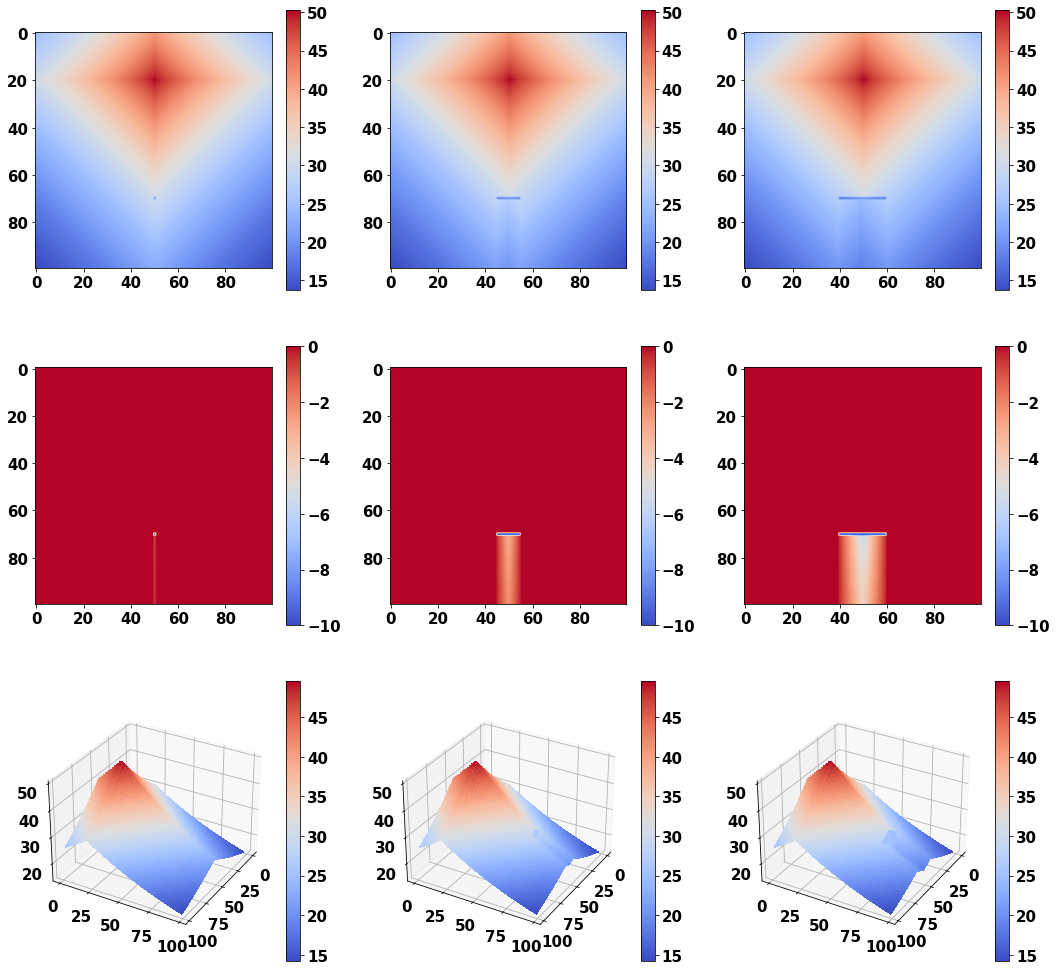

In [67]:
plots = [V_1, V_2, V_3]

plot_them( V_base, plots )

plt.savefig( 'future_stoch_neg_bar.eps', format='eps', dpi=75 )

So what's going on here is that the solid line of negative reward casts a shadow, but this shadow is representing what action needs to be taken to get out from behind that line of negative reward.  We ss this as the dark blue trench that is down stream from the line of negative reward, where the agent will first try to go either right or left to climb out of the trench so that it can go around the line of negative reward.

Let's drop a block of negative reward down and see what happens.  We should see some element of the negative reward propagation mixing with this.



In [68]:
R = np.zeros( dims )

# define some rewards in the reward function
# NOTE: reward magnitudes chosen here for best visibility in the plots.  chose them experimentally.

R[ 20,50 ] = 1

R[ 60:61,40:60 ] = -2
V_4 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

R[ 60:65,40:60 ] = -2
V_5 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

R[ 60:70,40:60 ] = -2
V_6 = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )


(98, 98) (100, 100)
(98, 98) (100, 100)
(98, 98) (100, 100)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


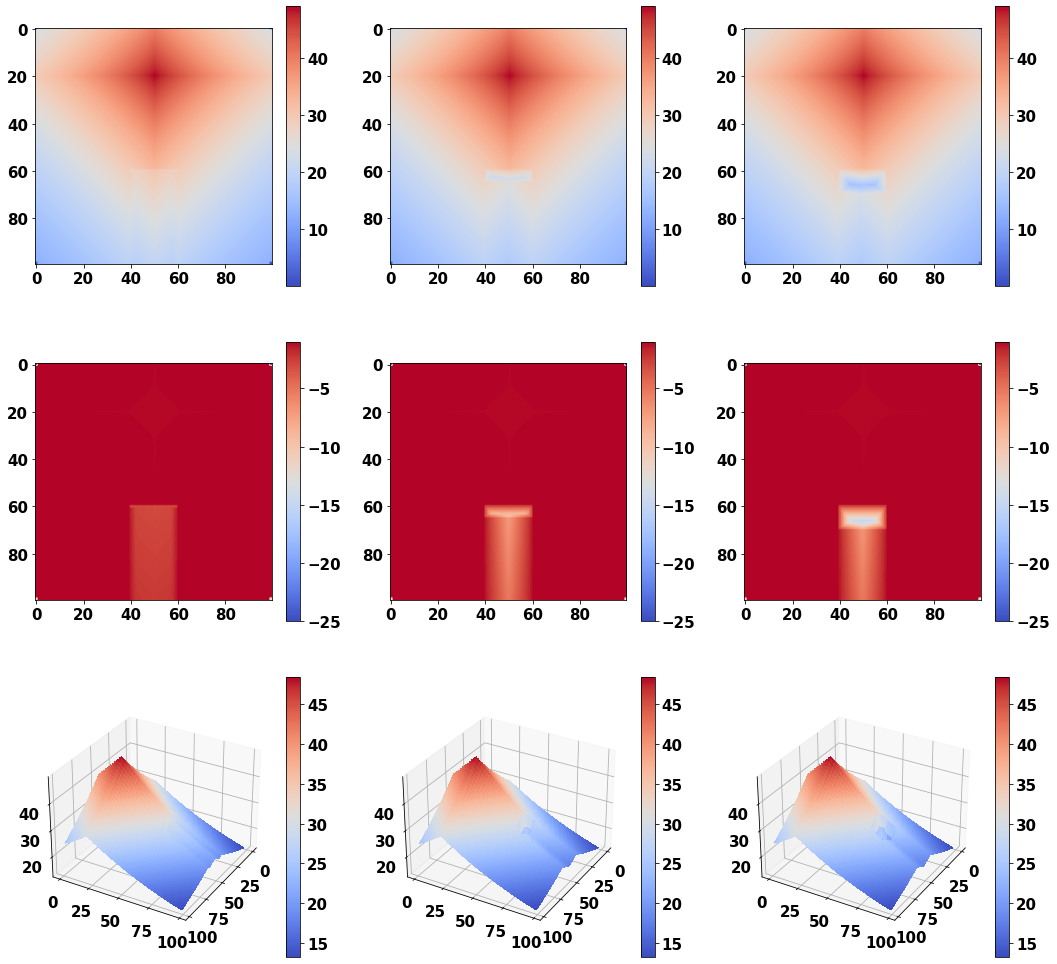

In [69]:
plot_them( V_base, [ V_4, V_5, V_6 ] )

plt.savefig( 'future_stoch_neg_rect.eps', format='eps', dpi=75 )

Lets see if we can reconstruct these value functions with a linear combination of the component reward funcitons.  I think the answer is going to be no due to the "shadow" effect creating asymmetry on each side of the negative rewards, but let's see.

In [59]:
R = np.zeros( dims )

# Find the value function with only the negative rewards from V_5.
R[ 60:65,40:60 ] = -2
V_5a = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )



(98, 98) (100, 100)
(98, 98) (100, 100)
(98, 98) (100, 100)


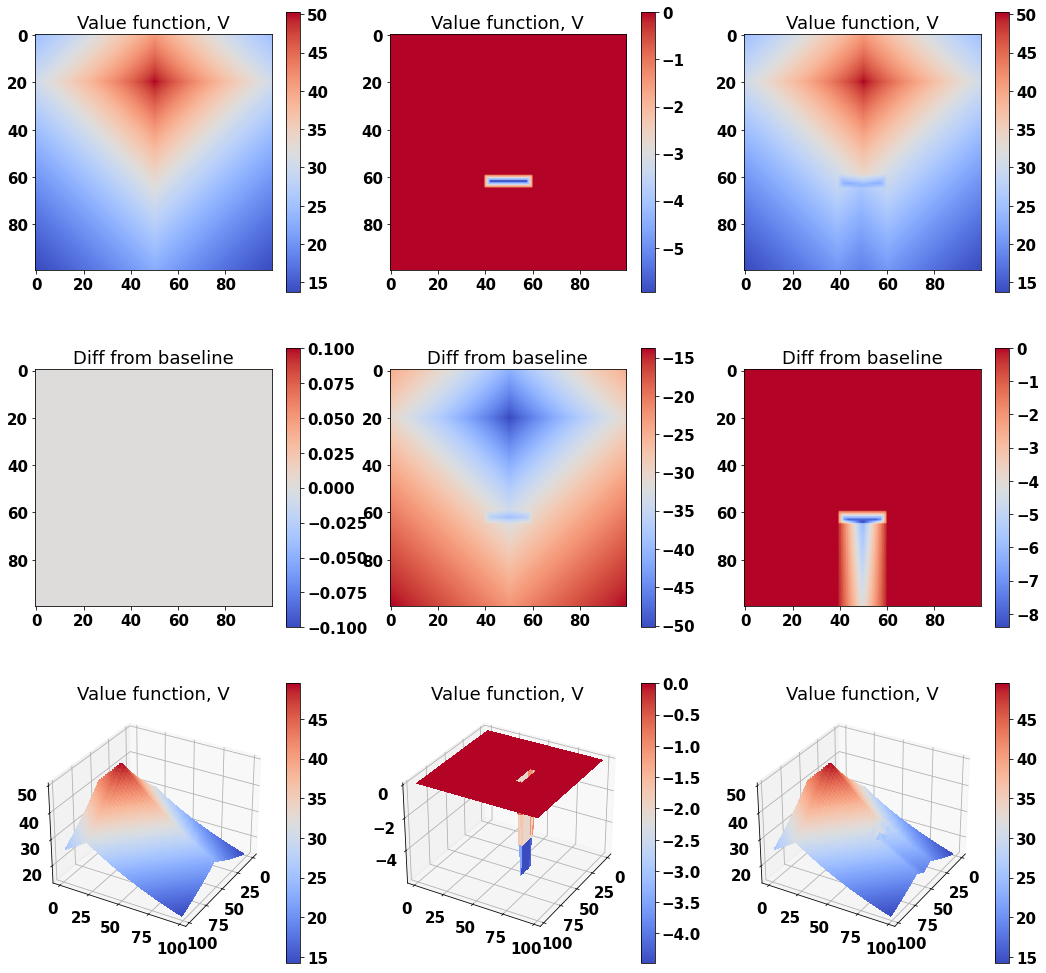

In [60]:
# Plot the component parts.  (These plots may not make a whole lot of sense.)
plot_them( V_base, [ V_base, V_5a, V_5 ] )


(98, 98) (100, 100)


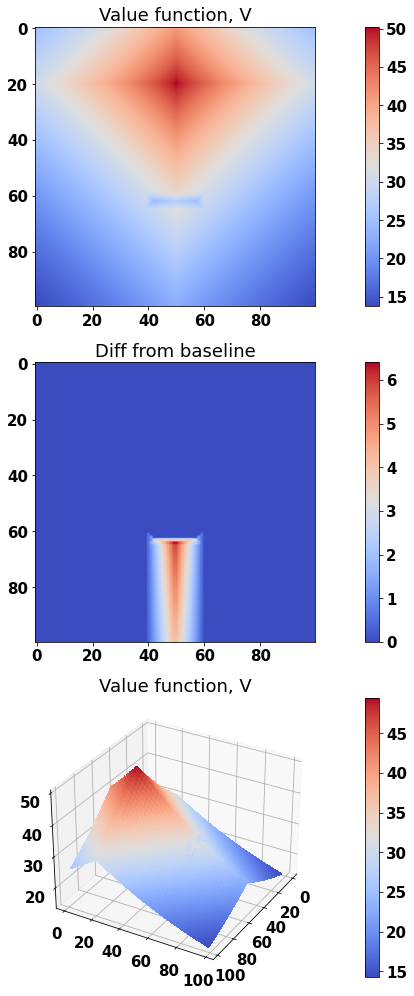

In [61]:
# Now see if we can constrct V_5
plot_them( V_5, [ V_base + V_5a ] )

In [62]:
# Note, can we propagate forward multiple actions in stochastic MDP and then determine mean result as a way of solving stochastic MPD.